In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import calendar
from scipy import integrate

# I. Data processing and preliminary analysis

We first get the data of the specific car park and then clean it to generate a dataframe. 

In [2]:
def getDayName(d):
    return calendar.day_name[d.weekday()]

available_parkings = ['Granollers_Estable', 'SantSadurni_Estable', 'SantBoi_Estable', 'Vilanova_Estable', 'quatrecamins']
current_parking = available_parkings[0]
df = pd.read_csv('data/'+current_parking+".csv", delimiter=";")
df = df.dropna()
df['Date'] = df['DateTime'].apply(lambda x: x.split(' ')[0])
df['Time'] = df['DateTime'].apply(lambda x: x.split(' ')[1])
df['Free slots'] = df['Parking Granollers Renfe plazas totales'].apply(lambda x: int(x.split(',')[0]))
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df.sort_values(by="Date")
df['Weekday'] = df.apply(lambda x: getDayName(x['Date']),axis=1)
df['Date'] = [d.date().strftime("%Y-%m-%d") for d in df['Date']]
df = df.drop(['DateTime'], axis=1)
df = df.drop(['Parking Granollers Renfe plazas totales'], axis=1)

max_value = df["Free slots"].max()
min_value = df["Free slots"].min()
df['Occupancy'] = df['Free slots'].map(lambda x: max_value-x)
axis_ylim = max_value+20
axis_ylim_low = 0
print('Y lim: ' ,axis_ylim)
df.head()

Y lim:  198


Date  Time  Free slots Weekday  Occupancy
254  2020-01-06  7:00         176  Monday          2
255  2020-01-06  7:30         176  Monday          2
256  2020-01-06  8:00         176  Monday          2
257  2020-01-06  8:30         176  Monday          2
258  2020-01-06  9:00         176  Monday          2

In [3]:
# GLOBAL VARIABLES THAT MUST BE FILLED ALONG THE Jup. NOTEBOOK FOR THE EXPORT
max_capacity = max_value

hist_weekday_proto = []
hist_friday_proto  = []
hist_weekend_proto = []

gammix_weekday_pars = []
gammix_friday_pars  = []
gammix_weekend_pars = []

gammix_weekday_proto = []
gammix_friday_proto  = []
gammix_weekend_proto = []

time = np.linspace(0,23.5,48)

### Delete days that have not to be taken into account

All outliers and covid-affected days are erased as not to disturb the results. 

In [4]:
days_list = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06', '2020-02-06', '2020-02-07', '2020-02-23', '2020-02-28', '2020-03-15',
             '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-14',
             '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-02-29','2020-03-31', '2020-03-13']

def checkDataValidty(date):
    if date in days_list: 
        return False
    else:
        return True

In [5]:
df['Stable Data'] = df['Date'].apply(lambda x: checkDataValidty(x))
df_holidays = df[df['Stable Data'] == False]
df = df[df["Stable Data"] == True]

## Mean free slots by weekday

In [6]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_days = df.groupby([df['Weekday']], as_index=False).mean()

# REORDER BY DAY
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = df_days['Weekday'].map(mapping)
df_days = df_days.iloc[key.argsort()]
df_days.reset_index(inplace=True, drop=True) 

In [7]:
# x = df_days['Weekday']
# y = df_days['Occupancy']
# fig, ax = plt.subplots(figsize=(15,5))
# plt.plot(x,y, label='Value')
# plt.plot(x,y,'o')
# plt.title('Mean occupancy by day until end of March in '+current_parking, fontsize=14)
# plt.xlabel('Date', fontsize = 12)
# plt.ylabel('Occupancy', fontsize = 12)
# plt.legend()
# plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
# df = df.reset_index(drop = True)

## Compute the mean for different days

In [8]:
def toAbsHour(hour):
    beginning = [int(s) for s in hour.split(':')]
    absol_hour = (beginning[0] + beginning[1]/60 )
    return absol_hour

df_byhour = df
df_byhour['ABS_Hour'] = df_byhour['Time'].apply(lambda x: toAbsHour(x) )

df_hours = df_byhour
df_hours['hour'] = df_hours['ABS_Hour'].map(lambda x: (int(2*x))/2)


# Normalization

Both area and normalization functions are defined to transform the occupancy profiles to occupancy probability profiles.

In [9]:
def Area_by_date(date):
    df_day = df[(df['Date'] == date)]
    Profile = df_day['Occupancy'].values
    Area = integrate.simps(Profile)
    return Area

df_hours['Area'] = df_hours['Date'].apply(lambda x: Area_by_date(x))

def df_normalization(occ, area):
    if area == 0:
        return 'error'
    return occ/area

df_hours['Normalized_occupancy'] = df_hours.apply(lambda x: df_normalization(x.Occupancy, x.Area), axis=1)

#df_hours = df_hours.drop(['Occupancy'], axis=1)
#df_hours['Occupancy'] = df_hours['Normalized_occupancy'].apply(lambda x: x)
df_mean_slots = df_hours.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()

In [10]:
mean_occupancy = df_mean_slots['Occupancy']

In [11]:
Monday_occ = mean_occupancy['Monday']
Tuesday_occ = mean_occupancy['Tuesday']
Wednesday_occ = mean_occupancy['Wednesday']
Thursday_occ = mean_occupancy['Thursday']
Friday_occ = mean_occupancy['Friday']
Saturday_occ = mean_occupancy['Saturday']
Sunday_occ = mean_occupancy['Sunday']

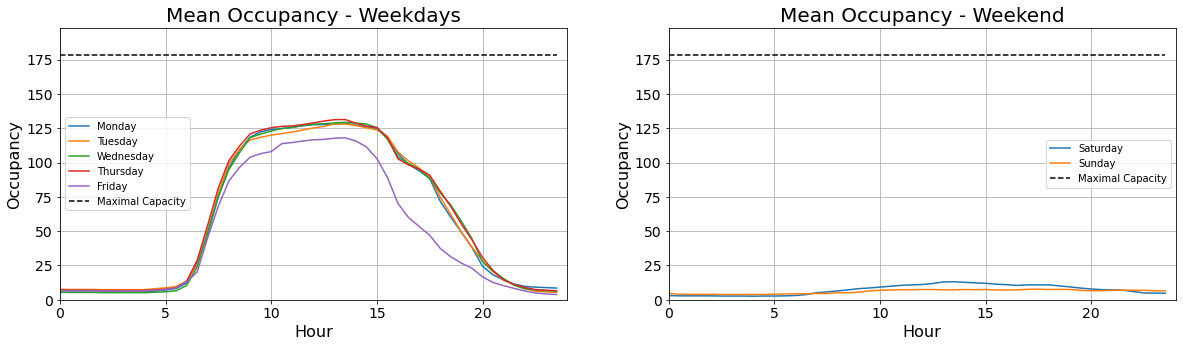

In [12]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
maximal_line = np.zeros(48)+max_value;
time=np.linspace(0,23.5,48);


plt.plot(Monday_occ,label='Monday')
plt.plot(Tuesday_occ,label='Tuesday')
plt.plot(Wednesday_occ,label='Wednesday')
plt.plot(Thursday_occ, label='Thursday')
plt.plot(Friday_occ,label='Friday')
plt.plot(time, maximal_line,'--',color='black',label='Maximal Capacity')

plt.title('Mean Occupancy - Weekdays', fontsize=20)
plt.xlabel('Hour', fontsize=16); plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(labelsize=14)
plt.axis([0, 24, 0, axis_ylim])
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(Saturday_occ,label='Saturday')
plt.plot(Sunday_occ,label='Sunday')
plt.plot(time, maximal_line,'--',color='black',label='Maximal Capacity')

plt.title('Mean Occupancy - Weekend', fontsize=20)
plt.xlabel('Hour', fontsize=16); plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(labelsize=14)
plt.axis([0, 24, 0, axis_ylim])
plt.legend()
plt.grid()

## Variance computation

In [13]:
def mean_day(Weekday,date):
    df = df_hours[(df_hours['Weekday'] == Weekday)]
    df_day = df[(df['Date'] == date)]
    df_day_mean = df_day.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Weekday]
    return Day

def generate_mean_variance(accumulated_date, accumulated_free_slots):
    aux_dict = {};
    for ii in np.arange(len(accumulated_date)):
        free_slots = list(accumulated_free_slots[ii].iat)
        hour = list(accumulated_free_slots[ii].index)
        for jj in np.arange(len(free_slots)):
            current_hour = hour[jj]
            if current_hour not in aux_dict:
                aux_dict[current_hour] = []
            aux_dict[current_hour].append(free_slots[jj])
    return aux_dict

def compute_mean_variance(aux_dict):
    domain = np.linspace(0,23,47)
    var_vec = []; mean_vec = []; hour_vec=[];
    for ii in domain:
        if ii in aux_dict:
            var_vec.append(np.var(list(aux_dict[ii])))
            mean_vec.append(np.mean(list(aux_dict[ii])))
            hour_vec.append(ii)
    return var_vec, mean_vec, hour_vec

### Visualize days

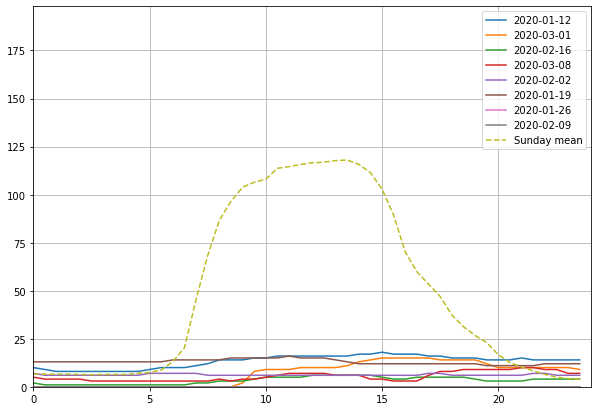

In [14]:
Weekday = 'Sunday'
Day_df = df_hours[(df_hours['Weekday'] == Weekday)]
dates = Day_df['Date']
dates_options = set(dates[:][:])
dates_options = list(dates_options)
lockdown_dates=[];
#lockdown_dates.append('06/01/2020')
# lockdown_dates.append('16/01/2020')
# lockdown_dates.append('30/01/2020')
# lockdown_dates.append('23/01/2020')

fig = plt.figure(figsize = (10,7))
accumulated_free_slots=[];
accumulated_date=[];

for ii in np.arange(len(dates_options)):
    day = dates_options[ii]
    Day = mean_day(Weekday,day)
    aux_vec=np.zeros(24)
    Day_list = list(Day)
    accumulated_date.append(day)
    accumulated_free_slots.append(Day)
    plt.plot(Day,label=day)
    
label_tag = Weekday + ' mean'
plt.plot(Friday_occ,'--', label = label_tag)
plt.axis([0, 24, axis_ylim_low, axis_ylim])
plt.grid()
plt.legend()

# II. PREDICTION 

### Prepare the data for the prediction

In order to generate the predictions, different profiles are defined:
- A binary classification with Weekdays and Weekends. 
- Three different profiles with Weekdays, Fridays and Weekends. 

In [15]:
def classify_2_proto(x):
    weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    if x in weekday_list:
        return 'Weekday'
    else:
        return 'Weekend'


def classify_3_proto(x):
    weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
    weekend_list = ['Saturday', 'Sunday']
    if x in weekday_list:
        return 'Weekday'
    elif x in weekend_list:
        return 'Weekend'
    else:
        return 'Friday'
    

# 1 week data = 336 rows (48*7) WE ASUME WE HAVE COMPLETE DATA WITHOUT GAPS BETWEEN HOURS, AND DATA FROM 0.0 TO 23.5
# @from_end: if the testing data is retrieved from the last part of the df or from th beginning. By default, from the end
# @limit_date: if we want to get the train from specific date instead of by number of weeks

def split_data(df, n_test_weeks, limit_date = None, from_end=True): 
    if(limit_date != None):
        init_test = df[df['Date']==limit_date].index[0];
        end_test = df.shape[0]
        test_domain = range(init_test, end_test)
        test_domain = list(test_domain)

    else:
        if(from_end == True):
            end_test = df.shape[0]
            week_domain = n_test_weeks*336
            init_test = end_test-week_domain
            test_domain = range(init_test, end_test)
            test_domain = list(test_domain)
            
        elif(from_end == False):
            week_domain = n_test_weeks*336
            init_test = 0
            end_test = week_domain
            test_domain = range(0,week_domain)
            test_domain = list(test_domain)
            
    test_df = df[init_test:end_test]
    training_df = df.drop(test_domain)
    return training_df, test_df

In [16]:
df_byhour['MonthNumber']= df_byhour['Date'].apply(lambda x: x.split('-')[1])
df_prediction_mean = df_byhour.groupby(by=['Date','hour','MonthNumber','Weekday'], axis = 0, as_index=False).mean()
df_prediction_mean['Profile_2'] = df_prediction_mean['Weekday'].apply(lambda x: classify_2_proto(x))
df_prediction_mean['Profile_3'] = df_prediction_mean['Weekday'].apply(lambda x: classify_3_proto(x))

### Split data in Training/Testing df

In order to predict future occuupancies, the available data is splitted into two different datasets: One for training and one for testing. 

In [17]:
number_of_testing_weeks = 3
df_training, df_testing = split_data(df_prediction_mean, number_of_testing_weeks)
df_train_data = df_training
df_train_data.head(5)
df_testing.head()

Date  hour MonthNumber  Weekday  Free slots  Occupancy  \
1920  2020-02-18   0.0          02  Tuesday         178          0   
1921  2020-02-18   0.5          02  Tuesday         178          0   
1922  2020-02-18   1.0          02  Tuesday         178          0   
1923  2020-02-18   1.5          02  Tuesday         178          0   
1924  2020-02-18   2.0          02  Tuesday         178          0   

      Stable Data  ABS_Hour    Area Profile_2 Profile_3  
1920         True       0.0  2299.0   Weekday   Weekday  
1921         True       0.5  2299.0   Weekday   Weekday  
1922         True       1.0  2299.0   Weekday   Weekday  
1923         True       1.5  2299.0   Weekday   Weekday  
1924         True       2.0  2299.0   Weekday   Weekday

## III. PREDICTION BY MEAN

The historical mean of the already generated profiles is used to predict future behaviors. 

In [18]:
def mean_day_profile(Profile, df_aux):
    df = df_aux[(df_aux['Profile_2'] == Profile)]
    df_day_mean = df.groupby(by=['Profile_2','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Profile]
    return Day

def mean_of_day(Weekday,date):
    df = df_hours[(df_hours['Weekday'] == Weekday)]
    df_day = df[(df['Date'] == date)]
    df_day_mean = df_day.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Weekday]
    return Day

# Get all days of the type (Monday, Tuesday...) and return the mean of them
def get_days(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days

def get_days_of_protos(proto_name, df_):
    data_temp = df_[df_['Profile_3'] == proto_name] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days


In [19]:
# ------------------------ NEW TESTING DATA -----------------------------
# these variables are arrays of days
testing_mondays    = get_days("Monday", df_testing)
testing_tuesdays   = get_days("Tuesday", df_testing)
testing_wednesdays = get_days("Wednesday", df_testing)
testing_thursdays  = get_days("Thursday", df_testing)
testing_fridays    = get_days("Friday", df_testing)
testing_saturdays  = get_days("Saturday", df_testing)
testing_sundays    = get_days("Sunday", df_testing)

In [20]:
# a = [0,2,3,4,6]
# b = [1,1,1,1,1]
# c = np.array(a)+np.array(b)
# c/2

In [21]:
# ------------------------ TESTING DATA -----------------------------

real_monday = mean_of_day('Monday','2020-02-24')
real_tuesday = mean_of_day('Tuesday','2020-02-11')
real_wednesday = mean_of_day('Wednesday','2020-02-26')
real_thursday = mean_of_day('Thursday','2020-02-27')

################## Bad/None data on last Feb week ############################
real_friday = mean_of_day('Friday','2020-03-06') 
real_saturday= mean_of_day('Saturday','2020-03-07')
real_sunday = mean_of_day('Sunday','2020-03-01')

### 3 Prototypes: Weekday, Friday & Weekend

In [22]:
def mean_day_profile_3(Profile, df_aux):
    df = df_aux[(df_aux['Profile_3'] == Profile)]
    df_day_mean = df.groupby(by=['Profile_3','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    profile = mean_free_slots[Profile]
    return profile

In [23]:
# Obtain the 3 protoypes. IMPORTANT! We assume all the data in df is valid, robust and correct
def train_statistical_model(df): 
    df_day_mean = df.groupby(by=['Profile_3','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    return mean_free_slots['Weekday'], mean_free_slots['Friday'], mean_free_slots['Weekend'] 

weekdays = ['Monday', 'Thursday', 'Wednesday', 'Tuesday']
weekend= ['Saturday', 'Sunday']

# Simply return the proper prototype
def predict_full_day_statistical(day): 
    if day in weekdays: 
        return hist_weekday_proto
    elif day in weekend: 
        return hist_weekend_proto
    else:
        return hist_friday_proto


def get_proto_by_day(day_name):
    if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
        return 
    return


def get_scale_factor(current_data, proto):
    index = len(current_data)
    proto_val = proto[index-1]
    last_hour_val = current_data[-1]
    scaling = last_hour_val/proto_val
    return scaling 


def predict_real_time(day, current_hour, current_value, max_capacity, pred_type):
    if pred_type == "Stat":
        proto = get_proto_by_day(day) #Get from statistical prototypes
    else: 
        scale_factor = get_scale_factor(current_value, proto_value)
        prediction = np.array(proto)*scale_factor
    return prediction


In [24]:
hist_weekday_proto, hist_friday_proto, hist_weekend_proto = train_statistical_model(df_train_data)
prediction = predict_full_day_statistical('Monday')

#### Plotting  prototypes

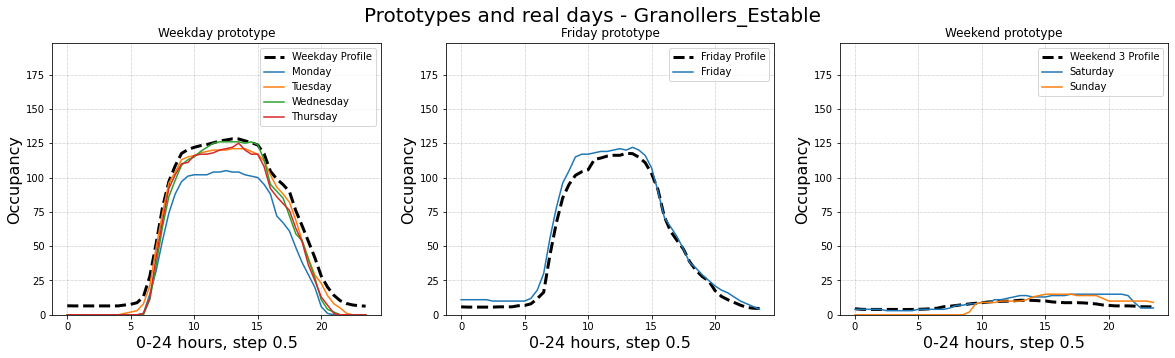

In [25]:
Weekday_proto = mean_day_profile_3('Weekday',df_train_data)
Weekend_proto = mean_day_profile_3('Weekend',df_train_data)
df_fri = df_train_data.drop(df_train_data[df_train_data['Date'] == '2020-02-07' ].index)
Friday_proto = mean_day_profile_3('Friday',df_fri)

fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.suptitle('Prototypes and real days - ' + current_parking, fontsize=20)

ax[0].plot(hist_weekday_proto, linestyle='--', label='Weekday Profile', color='k', linewidth=3)
ax[0].plot(real_monday.index.tolist(), real_monday.values.tolist(), label='Monday')
ax[0].plot(real_tuesday.index.tolist(), real_tuesday.values.tolist(), label='Tuesday')
ax[0].plot(real_wednesday.index.tolist(), real_wednesday.values.tolist(), label='Wednesday')
ax[0].plot(real_thursday.index.tolist(), real_thursday.values.tolist(), label='Thursday')
ax[0].set_ylim([0,axis_ylim])
ax[0].set_title("Weekday prototype")
ax[0].set_ylabel('Occupancy', fontsize=16)
ax[0].set_xlabel('0-24 hours, step 0.5', fontsize=16)
ax[0].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[0].legend()

ax[1].plot(hist_friday_proto, linestyle='--', label='Friday Profile', color='k', linewidth=3)
ax[1].plot(real_friday.index.tolist(), real_friday.values.tolist(), label='Friday')
ax[1].set_ylim([0,axis_ylim])
ax[1].set_title("Friday prototype")
ax[1].set_ylabel('Occupancy', fontsize=16)
ax[1].set_xlabel('0-24 hours, step 0.5', fontsize=16)
ax[1].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[1].legend()

ax[2].plot(hist_weekend_proto, linestyle='--', label='Weekend 3 Profile', color='k', linewidth=3)
ax[2].plot(real_saturday.index.tolist(), real_saturday.values.tolist(), label='Saturday')
ax[2].plot(real_sunday.index.tolist(), real_sunday.values.tolist(), label='Sunday')
ax[2].set_ylim([0,axis_ylim])
ax[2].set_title("Weekend prototype")
ax[2].set_ylabel('Occupancy', fontsize=16)
ax[2].set_xlabel('0-24 hours, step 0.5', fontsize=16)
ax[2].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[2].legend()


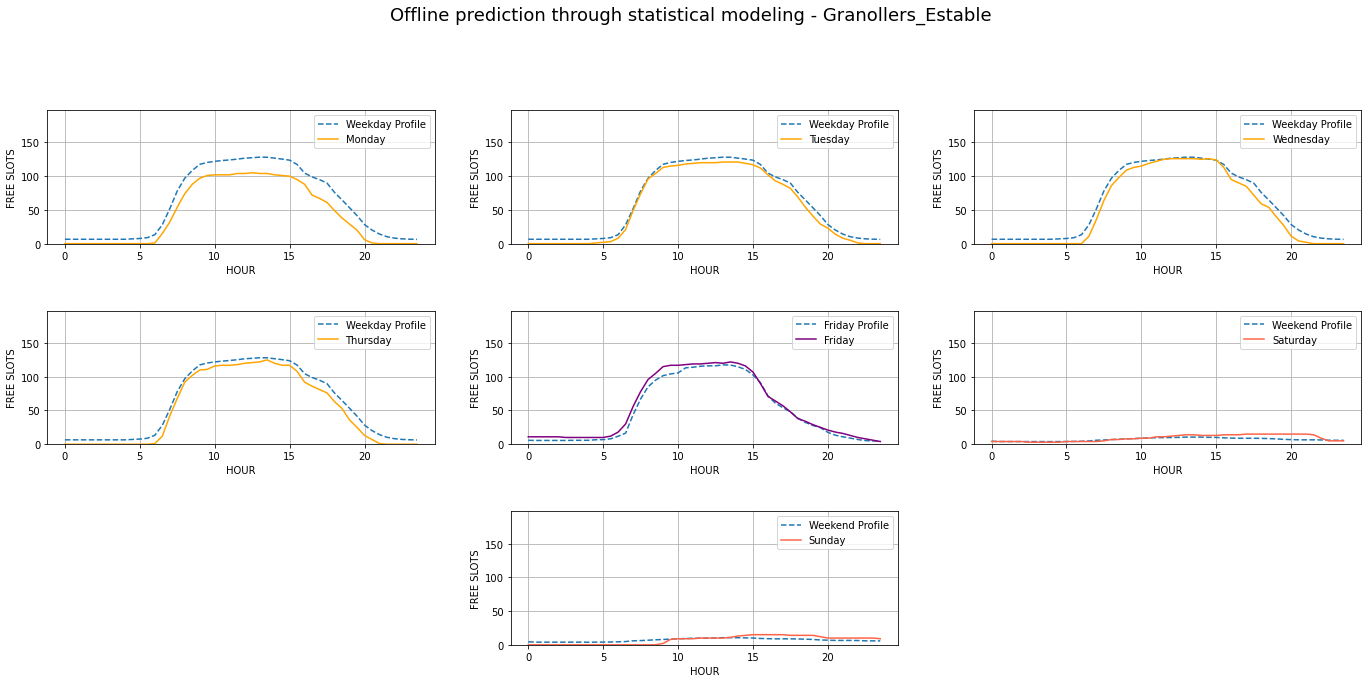

In [26]:
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('Offline prediction through statistical modeling - ' +  current_parking, fontsize=18)

axs[0, 0].plot(Weekday_proto, linestyle='--', label='Weekday Profile')
axs[0, 0].plot(real_monday.index.tolist(), real_monday.values.tolist(), label='Monday', color='orange')
axs[0, 0].set_ylim([axis_ylim_low,axis_ylim])

axs[0, 1].plot(Weekday_proto, linestyle='--', label='Weekday Profile')
axs[0, 1].plot(real_tuesday.index.tolist(), real_tuesday.values.tolist(), label='Tuesday', color='orange')
axs[0, 1].set_ylim([axis_ylim_low,axis_ylim])

axs[0, 2].plot(Weekday_proto, linestyle='--', label='Weekday Profile')
axs[0, 2].plot(real_wednesday.index.tolist(), real_wednesday.values.tolist(), label='Wednesday', color='orange')
axs[0, 2].set_ylim([axis_ylim_low,axis_ylim])

axs[1, 0].plot(Weekday_proto, linestyle='--', label='Weekday Profile')
axs[1, 0].plot(real_thursday.index.tolist(), real_thursday.values.tolist(), label='Thursday', color='orange')
axs[1, 0].set_ylim([axis_ylim_low,axis_ylim])

axs[1, 1].plot(Friday_proto, linestyle='--', label='Friday Profile')
axs[1, 1].plot(real_friday.index.tolist(), real_friday.values.tolist(), label='Friday', color='purple')
axs[1, 1].set_ylim([axis_ylim_low,axis_ylim])

Weekend_Day = mean_day_profile('Weekend',df_train_data)

axs[1, 2].plot(Weekend_proto, label='Weekend Profile', linestyle='--')
axs[1, 2].plot(real_saturday.index.tolist(), real_saturday.values.tolist(), color='tomato', label='Saturday')
axs[1, 2].set_ylim([axis_ylim_low,axis_ylim])

axs[2, 1].plot(Weekend_proto, label='Weekend Profile', linestyle='--')
axs[2, 1].plot(real_sunday.index.tolist(), real_sunday.values.tolist(), color='tomato', label='Sunday')
axs[2, 1].set_ylim([axis_ylim_low,axis_ylim])

axs[2,0].set_visible(False)
axs[2,2].set_visible(False)

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[2,1].legend()

axs[0,0].grid()
axs[0,1].grid()
axs[0,2].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[1,2].grid()
axs[2,1].grid()
fig.tight_layout(pad=5.0)

for ax in axs.flat:
    ax.set(xlabel='HOUR', ylabel='FREE SLOTS')

Text(0, 0.5, 'Occupancy')

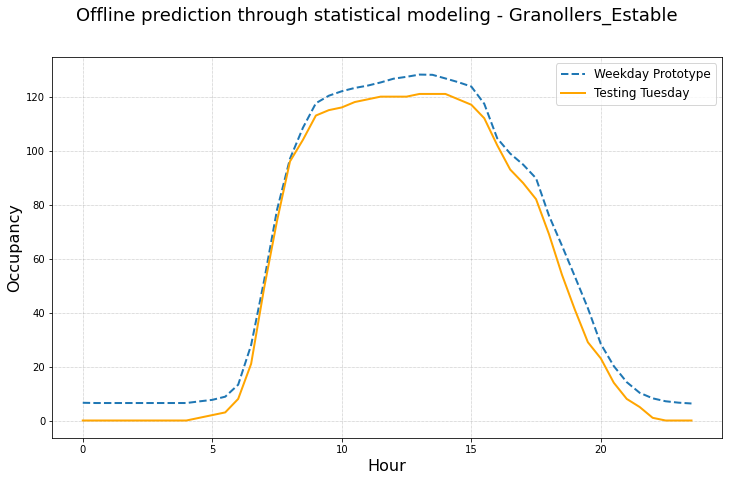

In [27]:
fig = plt.figure(figsize=(12,7))
fig.suptitle('Offline prediction through statistical modeling - ' + current_parking, fontsize=18)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
plt.plot(Weekday_proto, linestyle='--', linewidth=2, label='Weekday Prototype')
plt.plot(real_tuesday.index.tolist(), real_tuesday.values.tolist(), linewidth=2, label='Testing Tuesday', color='orange')
plt.legend(fontsize=12)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Occupancy', fontsize=16)

#### Computing errors for 3 prototypes

In [28]:
error_monday_3proto = np.absolute((np.array(Weekday_proto.values.tolist()) - np.array(real_monday.values.tolist())))

error_tuesday_3proto = np.absolute((np.array(Weekday_proto.values.tolist()) - np.array(real_tuesday.values.tolist())))

error_wednesday_3proto = np.absolute((np.array(Weekday_proto.values.tolist()) - np.array(real_wednesday.values.tolist())))

error_thursday_3proto = np.absolute((np.array(Weekday_proto.values.tolist()) - np.array(real_thursday.values.tolist())))

error_friday_3proto = np.absolute((np.array(Friday_proto.values.tolist()) - np.array(real_friday.values.tolist())))

error_saturday_3proto = np.absolute((np.array(Weekend_proto.values.tolist()) - np.array(real_saturday.values.tolist())))

error_sunday_3proto = np.absolute((np.array(Weekend_proto.values.tolist()) - np.array(real_sunday.values.tolist())))

In [29]:
error_monday_3proto = (error_monday_3proto/max_value)*100
error_tuesday_3proto = (error_tuesday_3proto/max_value)*100
error_wednesday_3proto = (error_wednesday_3proto/max_value)*100
error_thursday_3proto = (error_thursday_3proto/max_value)*100
error_friday_3proto = (error_friday_3proto/max_value)*100
error_saturday_3proto = (error_saturday_3proto/max_value)*100
error_sunday_3proto = (error_sunday_3proto/max_value)*100

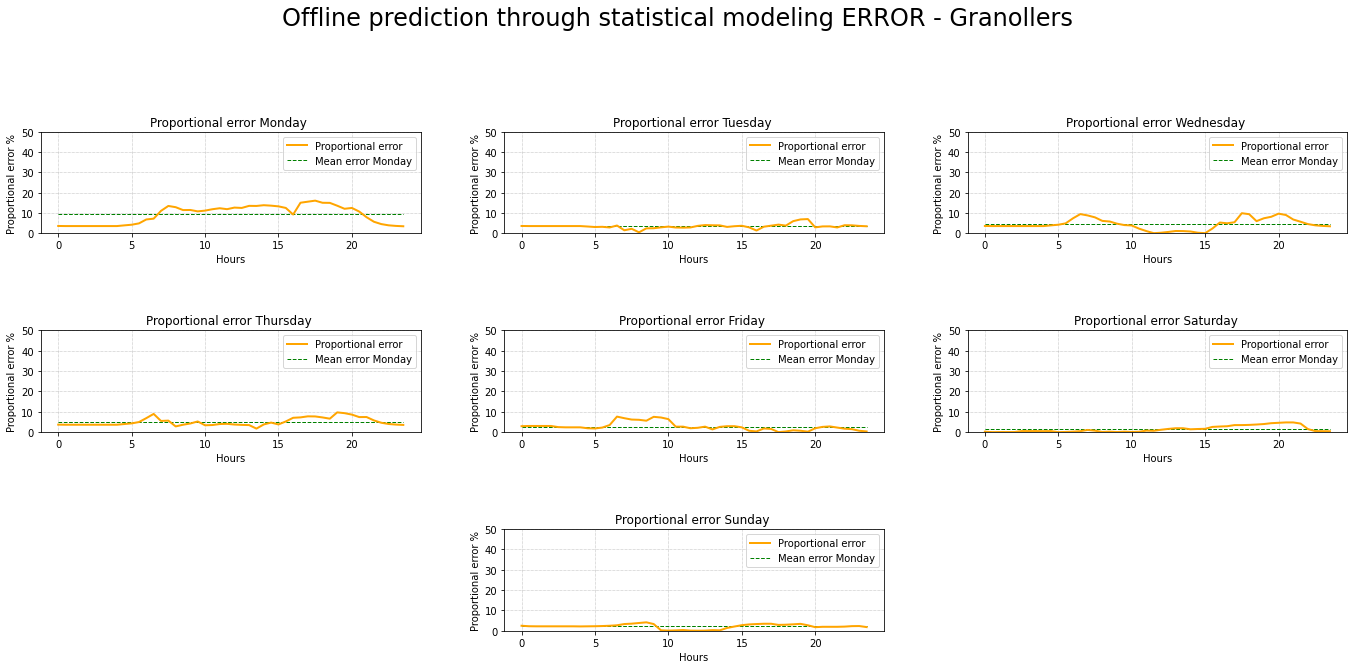

In [30]:
def subplotMeanProfileErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="orange", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='green', label='Mean error Monday')
    ax[axx,axy].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx,axy].legend(loc='upper left', fontsize=9)
    ax[axx,axy].set_ylabel('Proportional error %')
    ax[axx,axy].set_xlabel('Hours')
    ax[axx,axy].set_title(title)
    ax[axx,axy].set_ylim((0,50))
    ax[axx,axy].legend()

fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('Offline prediction through statistical modeling ERROR - Granollers', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 0, 0, time, error_monday_3proto, mean_Monday, 
                     'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 0, 1, time, error_tuesday_3proto, mean_Tuesday, 
                     'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 0, 2, time, error_wednesday_3proto, mean_Wednesday, 
                     'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 1, 0, time, error_thursday_3proto, mean_Thursday, 
                     'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 1, 1, time, error_friday_3proto, mean_Friday, 
                     'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 1, 2, time, error_saturday_3proto, mean_Saturday, 
                     'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_3proto)]*len(time)
subplotMeanProfileErr(fig, ax, 2, 1, time, error_sunday_3proto, mean_Sunday, 
                     'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)


for ax in axs.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)

(0.0, 30.0)

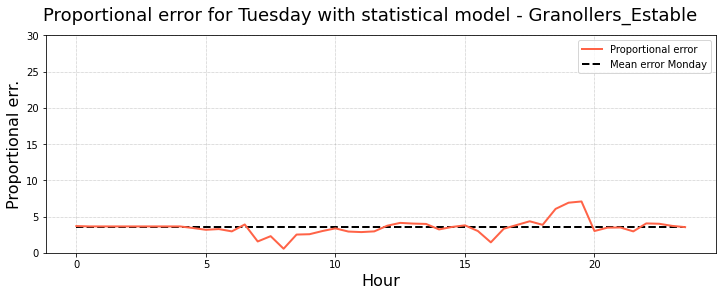

In [31]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Proportional error for Tuesday with statistical model - '+ current_parking, fontsize=18)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
plt.plot(real_tuesday.index.tolist(), error_tuesday_3proto, color="tomato", linewidth=2, zorder=10, label='Proportional error')
plt.plot(real_tuesday.index.tolist(), mean_Tuesday, linewidth=2, linestyle='--' ,color='black', label='Mean error Monday')
plt.legend()
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Proportional err.', fontsize=16)
plt.ylim([0,30])

## IV. Prediction of occupancy through Gammix fitting 

A Gammix function is defined to predict future occupancies taking advantage of some pretrained coefficients that charactarize each profile. 

In [32]:
from scipy.special import gamma, factorial
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def mix_gam_dis(x ,h, w1 ,b1 ,a1, w2, b2, a2):
    offset = h;
    wave1 = w1*((b1**a1)*((x)**(a1-1))*np.exp(-b1*(x)))/(gamma(a1)); 
    wave2 = w2*((b2**a2)*((x)**(a2-1))*np.exp(-b2*(x)))/(gamma(a2))
    total_wave = offset + wave1 + wave2    
    return total_wave

def gam(x,h,w,b,a):
     return h + w*((b**a)*((x)**(a-1))*np.exp(-b*(x)))/(gamma(a))
    
training_weekdays = get_days_of_protos("Weekday", df_training)
training_fridays = get_days_of_protos("Friday", df_training)
training_weekends = get_days_of_protos("Weekend", df_training)

time = np.linspace(0,23.5,48)
wd_length = len(training_weekdays)
f_length = len(training_fridays)
we_length = len(training_weekends)


def gammix_minimization_weekday(params):
    h= params[0]
    w1 = params[1]
    b1 = params[2]
    a1 = params[3]
    w2 = params[4]
    b2 = params[5]
    a2 = params[6]
    error = 0
    
    for ii in range(0,wd_length):
        day = training_weekdays[ii]
        error += mean_squared_error(mix_gam_dis(time, h, w1, b1, a1, w2, b2, a2), day)
    return error


def gammix_minimization_friday(params):
    h= params[0]
    w1 = params[1]
    b1 = params[2]
    a1 = params[3]
    w2 = params[4]
    b2 = params[5]
    a2 = params[6]
    error = 0
    
    for ii in range(0,f_length):
        day = training_fridays[ii]
        error += mean_squared_error(mix_gam_dis(time, h, w1, b1, a1, w2, b2, a2), day)
    return error


def gammix_minimization_weekend(params):
    h= params[0]
    w1 = params[1]
    b1 = params[2]
    a1 = params[3]
    error = 0
    
    for ii in range(0,we_length):
        day = training_weekends[ii]
        error += mean_squared_error(gam(time, h, w1, b1, a1), day)
    return error


x0=np.array([11.06181831,1070.46002211,1.77165575,28.33766342,725.98982615,2.38364553,23.55637799])
x1=np.array([20,148,0.7,11])

# ************************** WEEKDAYS *********************************
res_weekday = minimize(gammix_minimization_weekday, x0, method='Nelder-Mead')

opt_params = res_weekday.x;
h= opt_params[0]
w1 = opt_params[1];
b1 = opt_params[2];
a1 = opt_params[3];
w2 = opt_params[4];
b2 = opt_params[5];
a2 = opt_params[6];

gammix_weekday = mix_gam_dis(time, h, w1, b1, a1, w2, b2, a2)
gam1_weekday = gam(time, h, w1, b1, a1)
gam2_weekday = gam(time, h, w2, b2, a2)

# ************************** FRIDAY *********************************
res_friday = minimize(gammix_minimization_friday, x0, method='Nelder-Mead')

opt_params = res_friday.x;
h= opt_params[0]
w1 = opt_params[1];
b1 = opt_params[2];
a1 = opt_params[3];
w2 = opt_params[4];
b2 = opt_params[5];
a2 = opt_params[6];

gammix_friday = mix_gam_dis(time, h, w1, b1, a1, w2, b2, a2)
gam1_friday = gam(time, h, w1, b1, a1)
gam2_friday = gam(time, h, w2, b2, a2)

# ************************** WEEKEND *********************************
res_weekend = minimize(gammix_minimization_weekend, x1, method='Nelder-Mead')

opt_params = res_weekend.x;
h= opt_params[0]
w1 = opt_params[1];
b1 = opt_params[2];
a1 = opt_params[3];
 
gam1_weekend = gam(time, h, w1, b1, a1)



Text(0, 0.5, 'Occupancy')

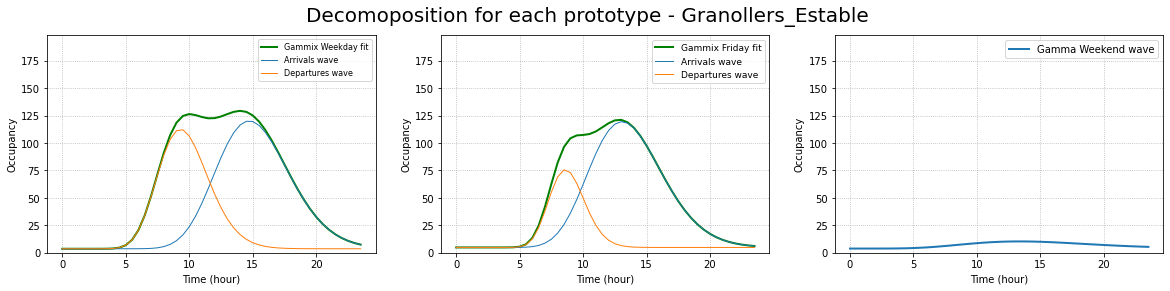

In [33]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype - ' + current_parking, fontsize=20)

ax[0].plot(time, gammix_weekday, linewidth=2, color= 'green', label='Gammix Weekday fit')
ax[0].plot(time, gam1_weekday, linewidth=1, label='Arrivals wave')
ax[0].plot(time, gam2_weekday, linewidth=1, label='Departures wave')
ax[0].set_ylim([0,axis_ylim])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Occupancy')

ax[1].plot(time, gammix_friday, linewidth=2, color= 'green', label='Gammix Friday fit')
ax[1].plot(time, gam1_friday, linewidth=1, label='Arrivals wave')
ax[1].plot(time, gam2_friday, linewidth=1, label='Departures wave')
ax[1].set_ylim([0,axis_ylim])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Occupancy')

ax[2].plot(time, gam1_weekend, linewidth=2, label='Gamma Weekend wave')
ax[2].set_ylim([0,axis_ylim])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Occupancy')

### Comparing gammix fitted prototype with testing data

In [34]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=2.5, linestyle='dashed', label= proto_name + ' prediction')
    ax[xx,yy].legend()
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=0.75, label='Testing ' + day )
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(0,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)')
    ax[xx,yy].set_ylabel('Occupancy')

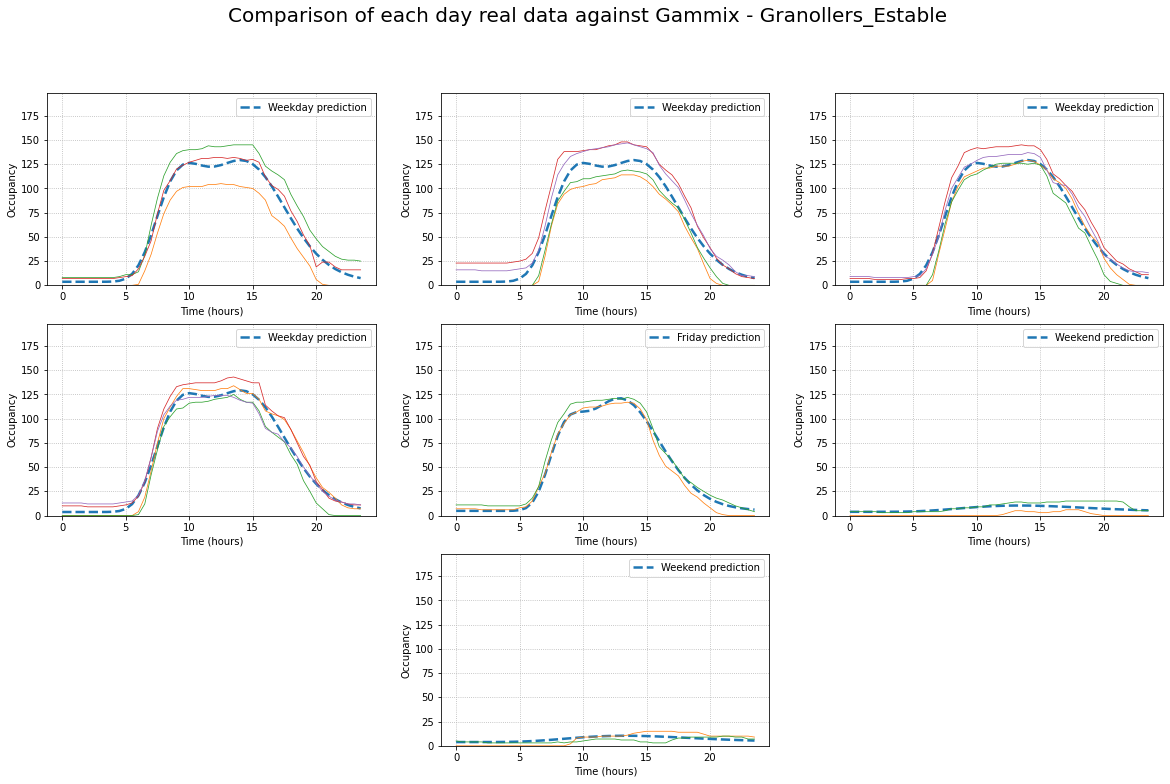

In [35]:
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Comparison of each day real data against Gammix - ' + current_parking, fontsize=20)

subplot_training(fig, ax, 0, 0, gammix_weekday, testing_mondays, 'Monday', 'Weekday')
subplot_training(fig, ax, 0, 1, gammix_weekday, testing_tuesdays, 'Tuesday', 'Weekday')
subplot_training(fig, ax, 0, 2, gammix_weekday, testing_wednesdays, 'Wednesday', 'Weekday')
subplot_training(fig, ax, 1, 0, gammix_weekday, testing_thursdays, 'Thursday', 'Weekday')
subplot_training(fig, ax, 1, 1, gammix_friday, testing_fridays, 'Friday', 'Friday')
subplot_training(fig, ax, 1, 2, gam1_weekend, testing_saturdays, 'Saturday', 'Weekend')
subplot_training(fig, ax, 2, 1, gam1_weekend, testing_sundays, 'Sunday', 'Weekend')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)

In [36]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_gammix = compute_testing_prop_error(testing_mondays, gammix_weekday)
error_tuesday_gammix = compute_testing_prop_error(testing_tuesdays, gammix_weekday)
error_wednesday_gammix = compute_testing_prop_error(testing_wednesdays, gammix_weekday)
error_thursday_gammix = compute_testing_prop_error(testing_thursdays, gammix_weekday)
error_friday_gammix = compute_testing_prop_error(testing_fridays, gammix_friday)
error_saturday_gammix = compute_testing_prop_error(testing_saturdays, gam1_weekend)
error_sunday_gammix = compute_testing_prop_error(testing_sundays, gam1_weekend)

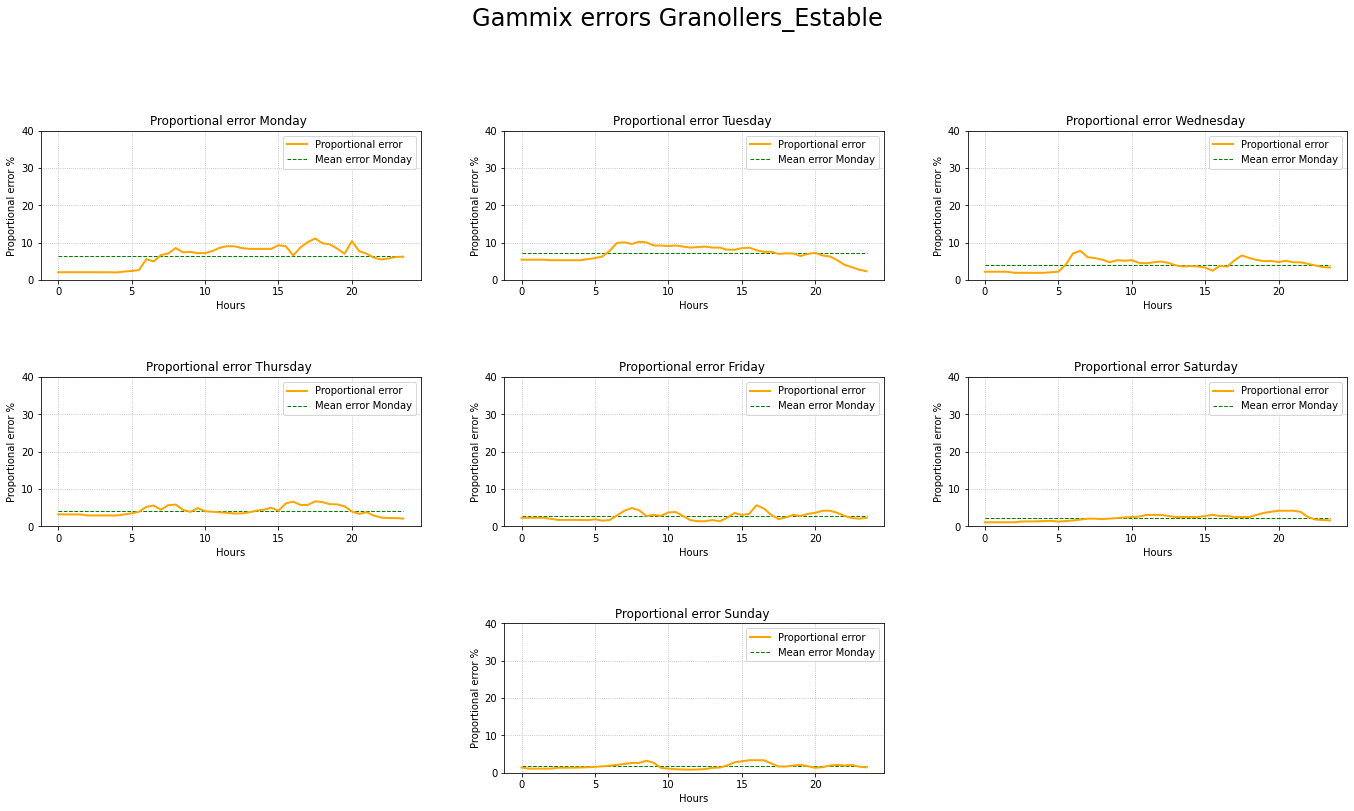

In [37]:
def subplotGammixErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="orange", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='green', label='Mean error Monday')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].legend(loc='upper left', fontsize=9)
    ax[axx,axy].set_ylabel('Proportional error %')
    ax[axx,axy].set_xlabel('Hours')
    ax[axx,axy].set_title(title)
    ax[axx,axy].set_ylim((0,40))
    ax[axx,axy].legend()
    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Gammix errors '+ current_parking, fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 0, time, error_monday_gammix, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 1, time, error_tuesday_gammix, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 2, time, error_wednesday_gammix, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 0, time, error_thursday_gammix, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 1, time, error_friday_gammix, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 2, time, error_saturday_gammix, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_gammix)]*len(time)
subplotGammixErr(fig, ax, 2, 1, time, error_sunday_gammix, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in axs.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)

(0.0, 30.0)

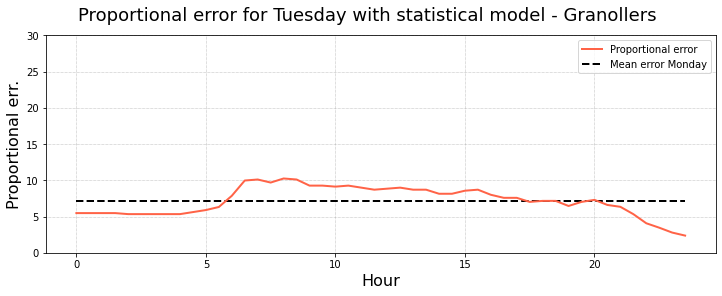

In [38]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Proportional error for Tuesday with statistical model - Granollers ', fontsize=18)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
plt.plot(real_tuesday.index.tolist(), error_tuesday_gammix, color="tomato", linewidth=2, zorder=10, label='Proportional error')
plt.plot(real_tuesday.index.tolist(), mean_Tuesday, linewidth=2, linestyle='--' ,color='black', label='Mean error Monday')
plt.legend()
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Proportional err.', fontsize=16)
plt.ylim([0,30])

### Gammix: Real time prediction by SCALING

In [39]:
# Plotting methods to reduce cell dimension

def real_timing_predition(fig, ax, axx, day, gammix_proto, real_day, scaled_proto, Prototype):
    fig.suptitle('Real time prediction Scaling gammix and mean proto for Testing ' + day, fontsize = 18)
    ax[axx].plot(time, gammix_proto,'--',color='grey', label='Gammix prototype (no scaled)')
    ax[axx].plot(time, real_day.values, color='tomato', linewidth=1, label='Real ' + day)
    ax[axx].plot(time, scaled_proto, color='green', linewidth=2, label='Gammix scaled proto')
    ax[axx].plot(time, Prototype, color='#069AF3', linewidth=2, label='Mean scaled proto')
    ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='Limit hour ')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend(fontsize=9)

def errors_plotting(fig, ax, axx, scaled_proto, Prototype, real_day, day):
    #Computing Errors
    gammix_scaled_error = (np.absolute((np.array(scaled_proto) - np.array(real_day.values)))/max_value)*100
    mean_scaled_error = (np.absolute((np.array(Prototype) - np.array(real_day.values)))/max_value)*100

    gammix_s_error_mean = [np.mean(gammix_scaled_error)]*len(gammix_scaled_error)
    mean_s_error_mean = [np.mean(mean_scaled_error)]*len(mean_scaled_error)

    #Second plot
    ax[axx].plot(time, gammix_scaled_error, color='tomato', label='Gammix scaling error')
    ax[axx].plot(time,gammix_s_error_mean, '--',color='tomato', label='Mean proportional error Gammix')
    ax[axx].plot(time,mean_scaled_error, color='blueviolet', label='Mean scaling error')
    ax[axx].plot(time,mean_s_error_mean, '--',color='blueviolet', label='Mean proportional error Mean')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend()
    ax[axx].set_ylim([0,20])

    print('Real ' + day + ' scaled prtotype error: ', round(100*mean_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled Gammix error: ', round(100*gammix_s_error_mean[0])/100, '%')

def get_scaling_factor(limit_hour, test_day, proto):
    index = limit_hour*2
    current_real_data = test_day.values[index]
    proto_value = proto[index]
    scaling = current_real_data/proto_value
    return scaling

#### MONDAY

Real Monday scaled prtotype error:  3.4 %
Real Monday scaled Gammix error:  3.56 %
Real Monday scaled prtotype error:  3.21 %
Real Monday scaled Gammix error:  3.54 %
Real Monday scaled prtotype error:  1.65 %
Real Monday scaled Gammix error:  2.05 %


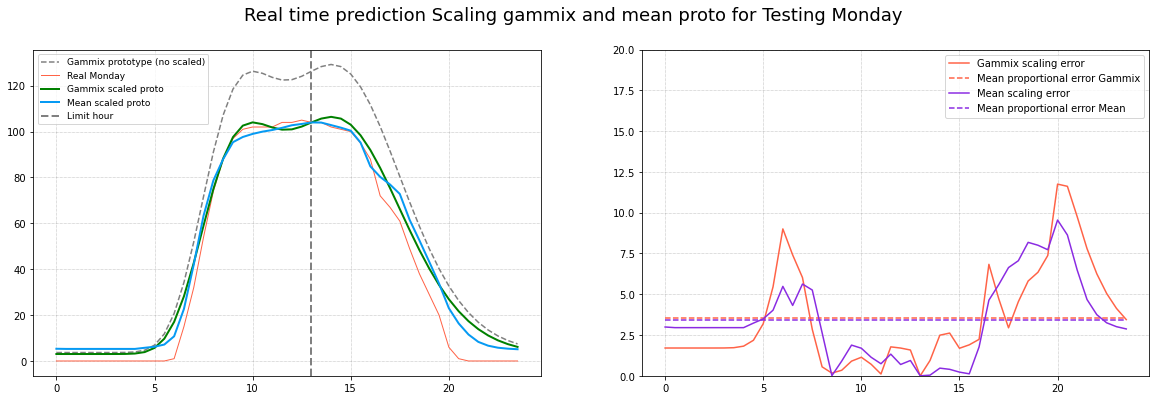

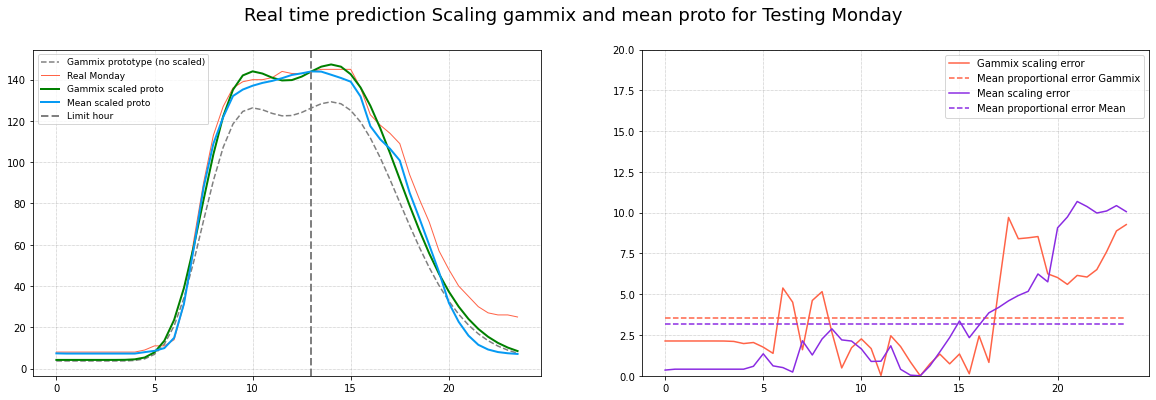

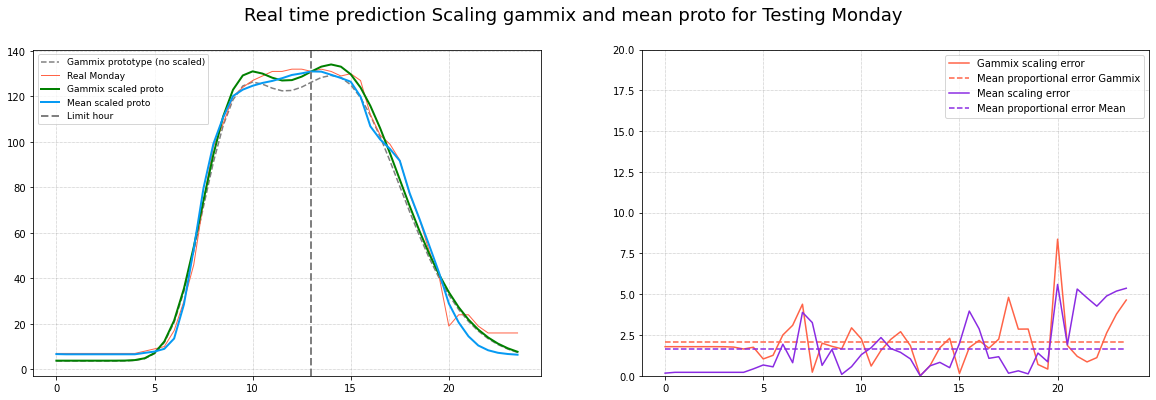

In [40]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_mondays
limit_hour = 13
day = 'Monday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

#### TUESDAY

Real Tuesday scaled prtotype error:  3.57 %
Real Tuesday scaled Gammix error:  4.06 %
Real Tuesday scaled prtotype error:  2.99 %
Real Tuesday scaled Gammix error:  3.5 %
Real Tuesday scaled prtotype error:  4.15 %
Real Tuesday scaled Gammix error:  5.07 %
Real Tuesday scaled prtotype error:  2.17 %
Real Tuesday scaled Gammix error:  2.85 %


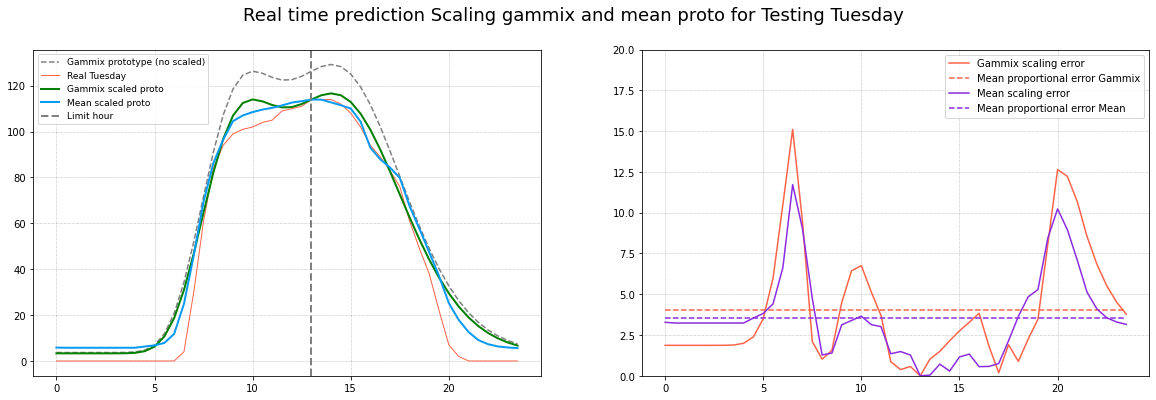

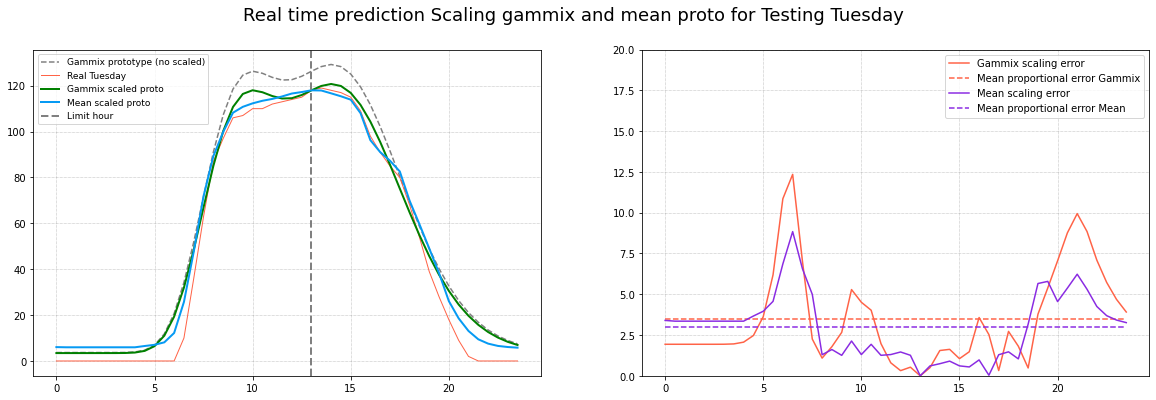

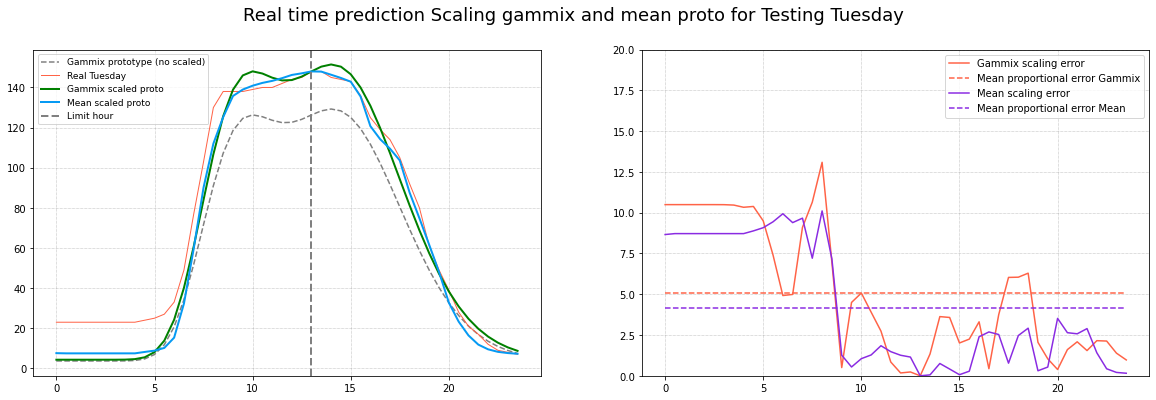

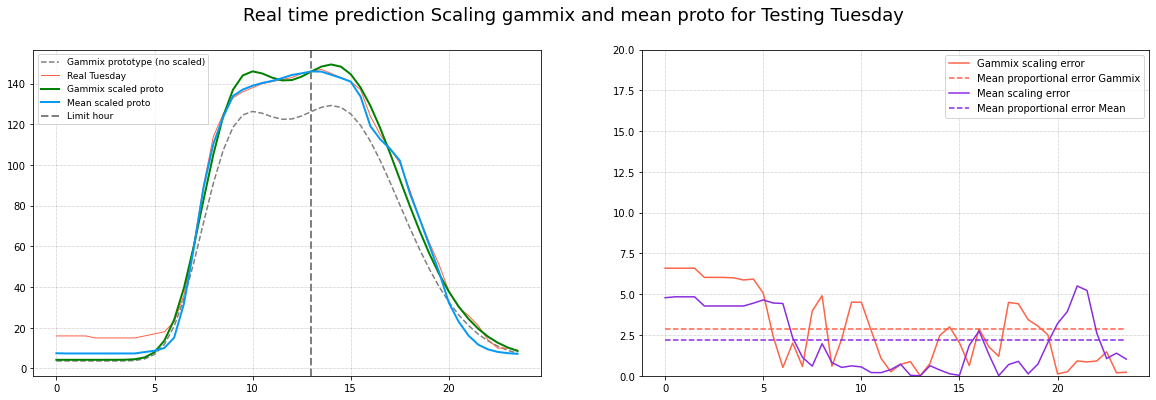

In [41]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_tuesdays
limit_hour = 13
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### WEDNESDAY

Real Wednesday scaled prtotype error:  3.07 %
Real Wednesday scaled Gammix error:  3.38 %
Real Wednesday scaled prtotype error:  4.22 %
Real Wednesday scaled Gammix error:  4.69 %
Real Wednesday scaled prtotype error:  1.61 %
Real Wednesday scaled Gammix error:  1.92 %
Real Wednesday scaled prtotype error:  1.44 %
Real Wednesday scaled Gammix error:  2.18 %


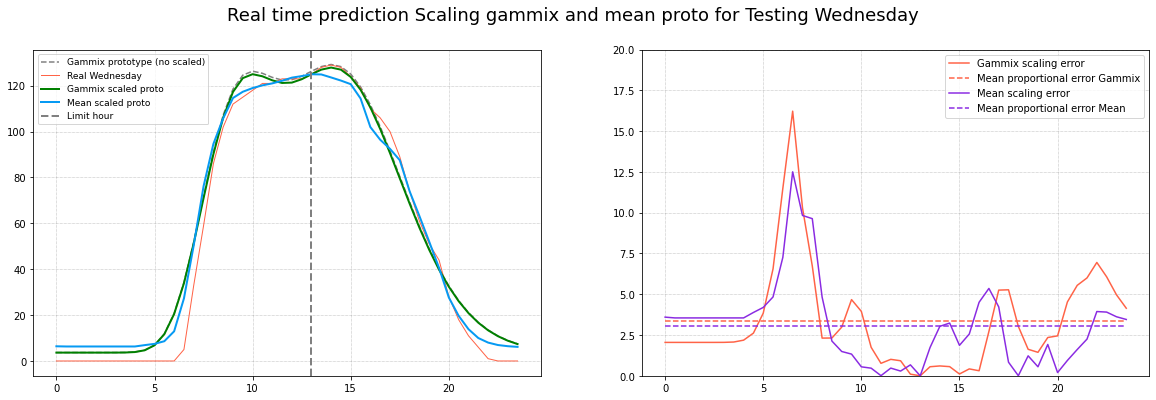

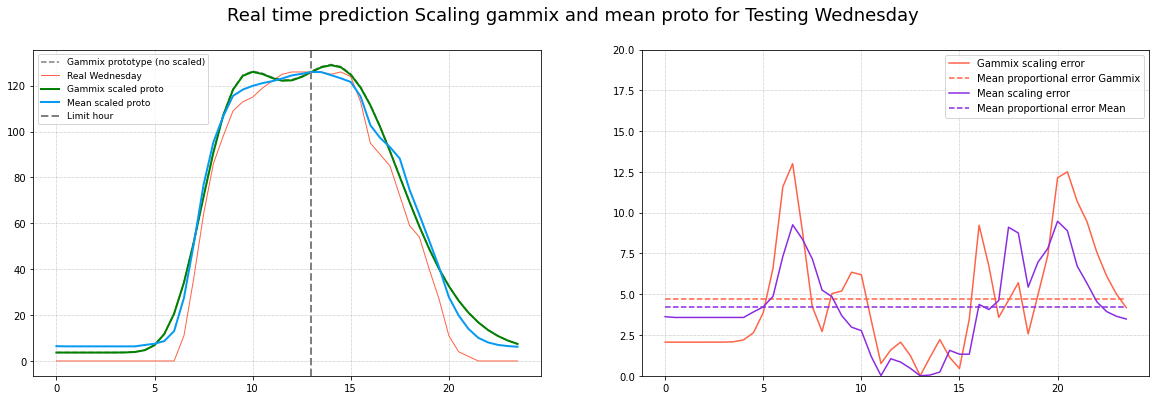

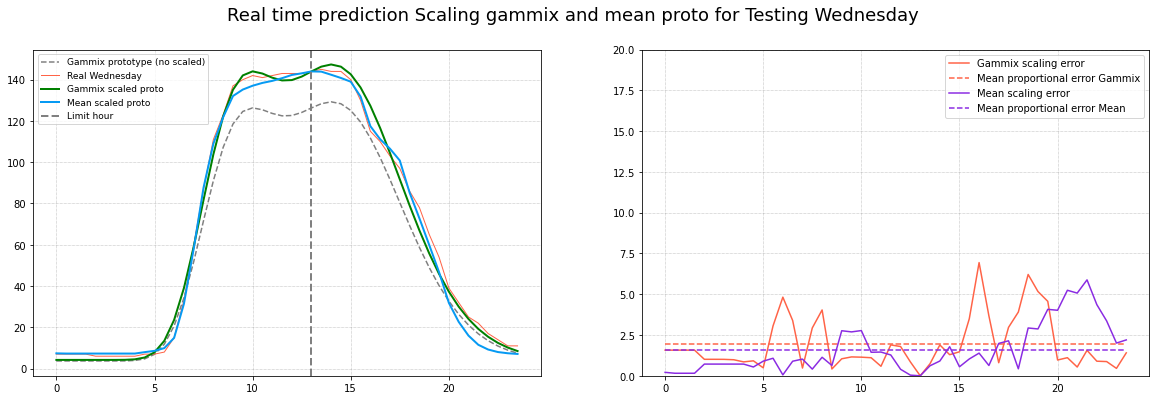

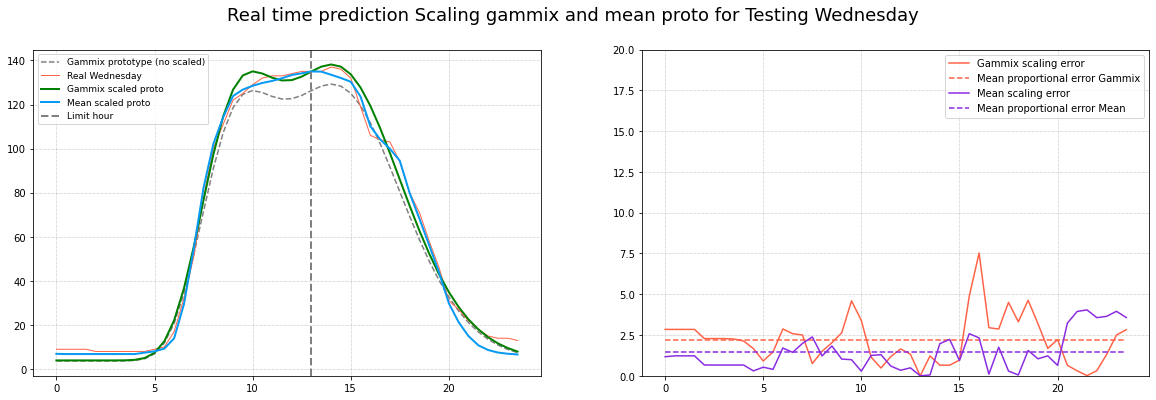

In [42]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_wednesdays
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### THURSDAY

Real Thursday scaled prtotype error:  2.9 %
Real Thursday scaled Gammix error:  2.86 %
Real Thursday scaled prtotype error:  3.46 %
Real Thursday scaled Gammix error:  4.05 %
Real Thursday scaled prtotype error:  1.47 %
Real Thursday scaled Gammix error:  2.35 %
Real Thursday scaled prtotype error:  3.12 %
Real Thursday scaled Gammix error:  3.16 %


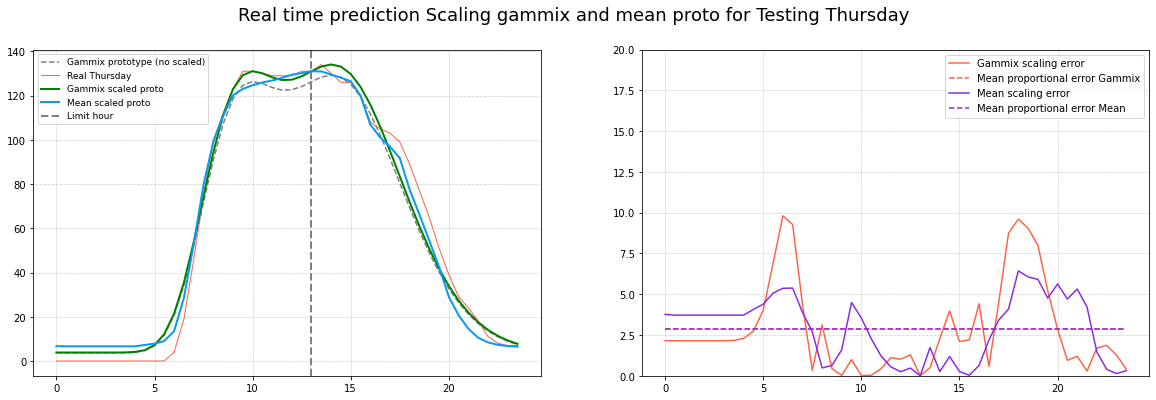

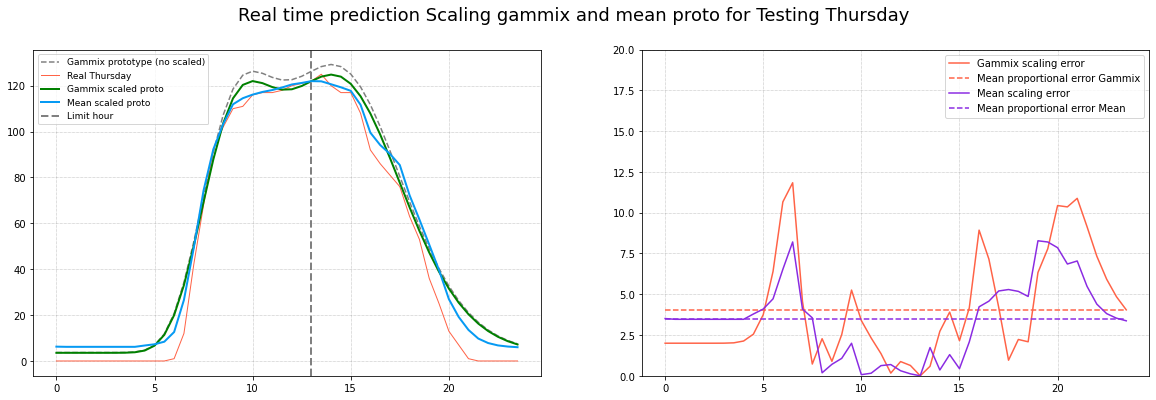

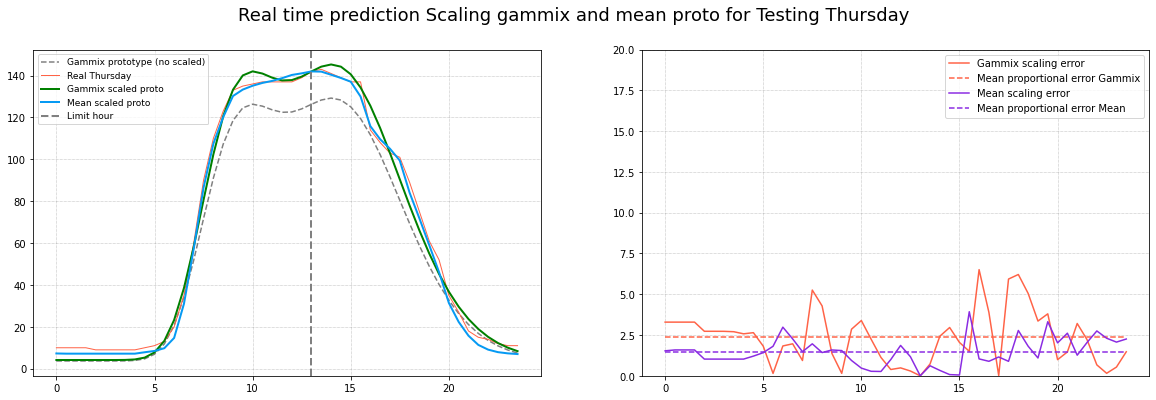

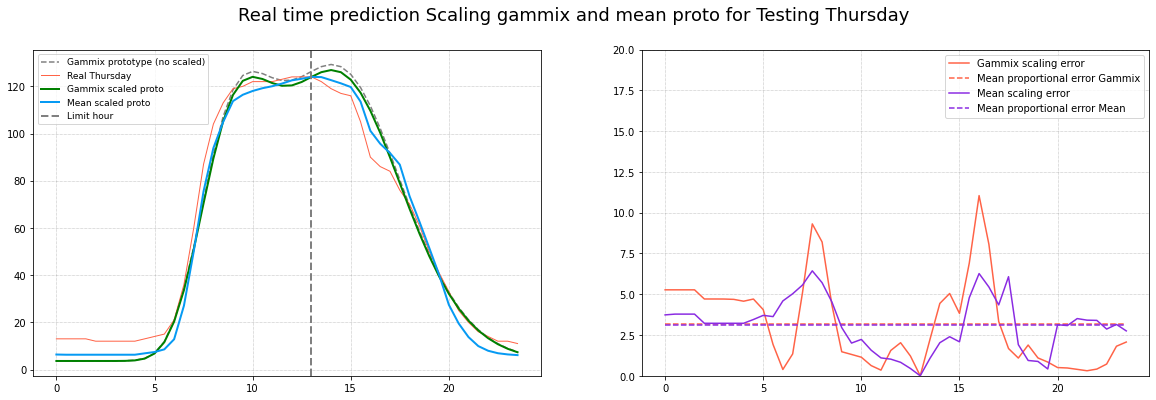

In [43]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_thursdays
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### FRIDAY

Real Friday scaled prtotype error:  5.2 %
Real Friday scaled Gammix error:  2.81 %
Real Friday scaled prtotype error:  4.36 %
Real Friday scaled Gammix error:  3.15 %


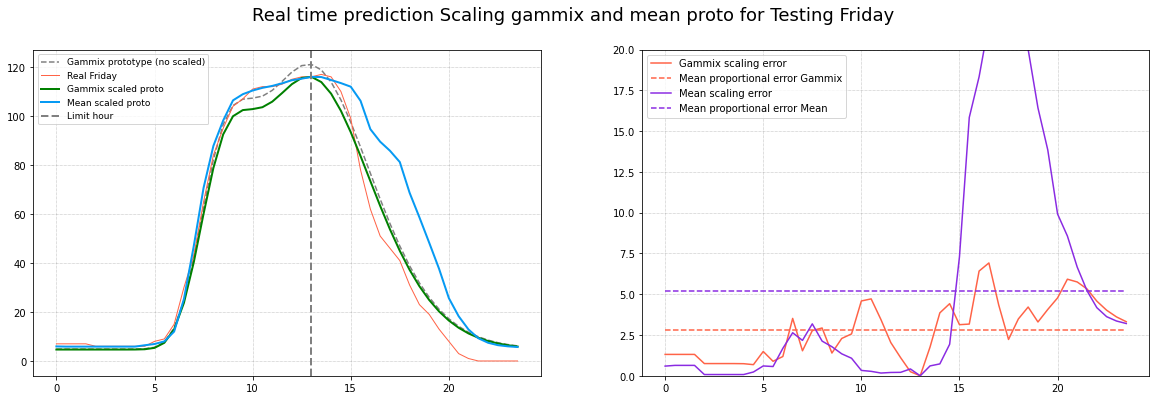

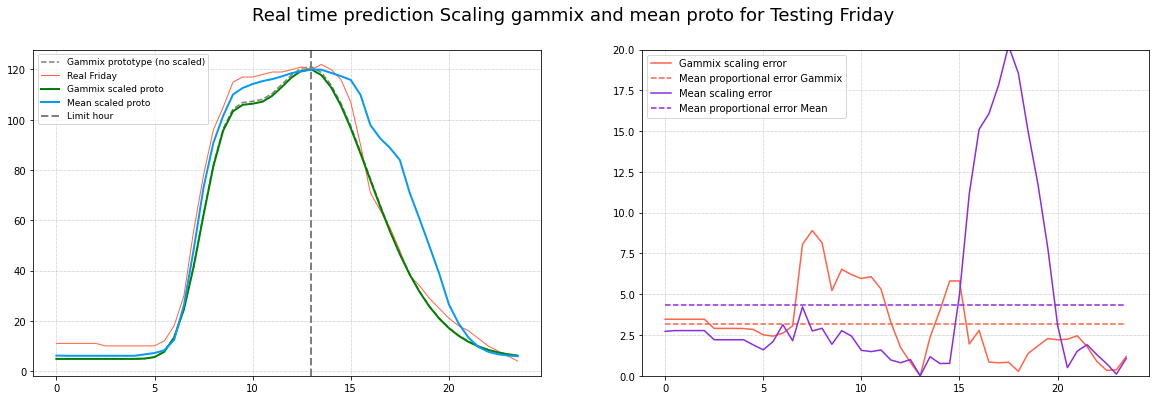

In [44]:
statistic_proto = hist_friday_proto
gammix_proto = gammix_friday
t_days = testing_fridays
limit_hour = 13
day = 'Friday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### WEEKEND

### SATURDAY

Real Saturday scaled prtotype error:  0.84 %
Real Saturday scaled Gammix error:  1.32 %
Real Saturday scaled prtotype error:  2.38 %
Real Saturday scaled Gammix error:  1.4 %


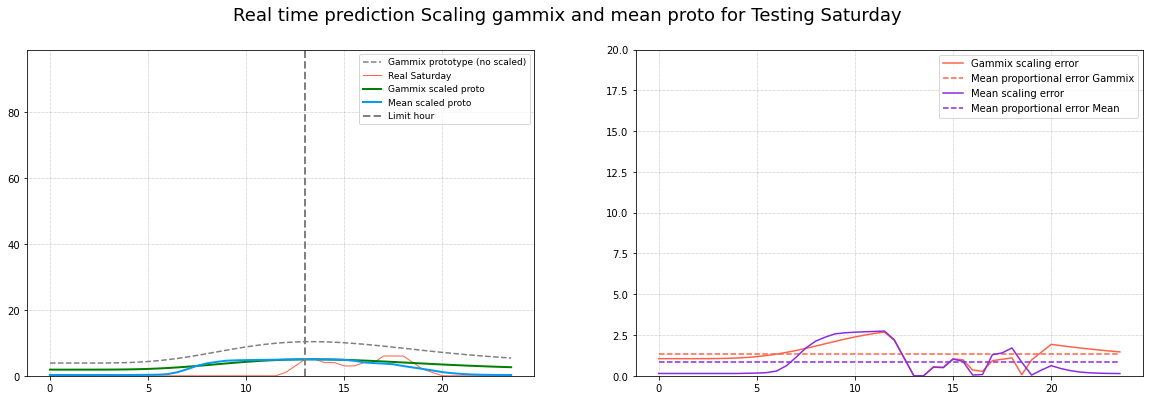

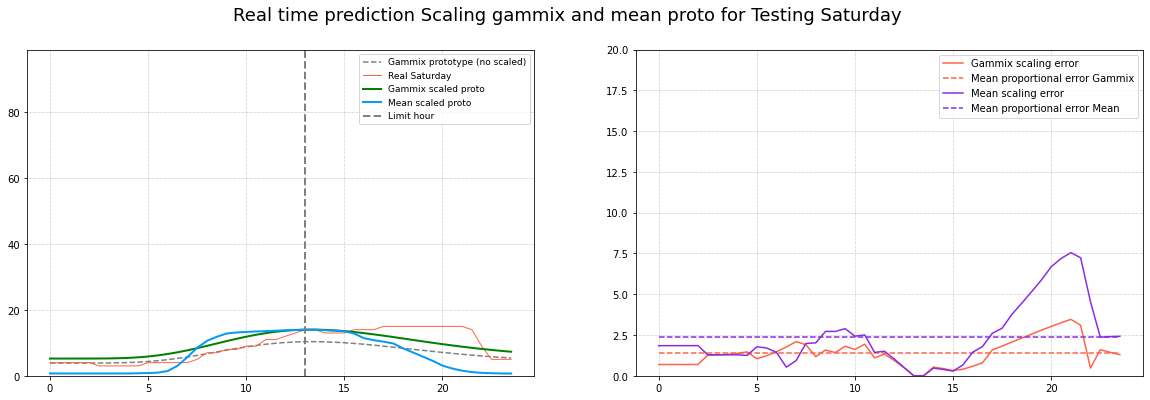

In [45]:
statistic_proto = hist_weekend_proto
gammix_proto = gam1_weekend
t_days = testing_saturdays
limit_hour = 13
day = 'Saturday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    ax[0].set_ylim([0,axis_ylim/2])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### SUNDAY

Real Sunday scaled prtotype error:  2.36 %
Real Sunday scaled Gammix error:  2.18 %
Real Sunday scaled prtotype error:  1.86 %
Real Sunday scaled Gammix error:  1.13 %


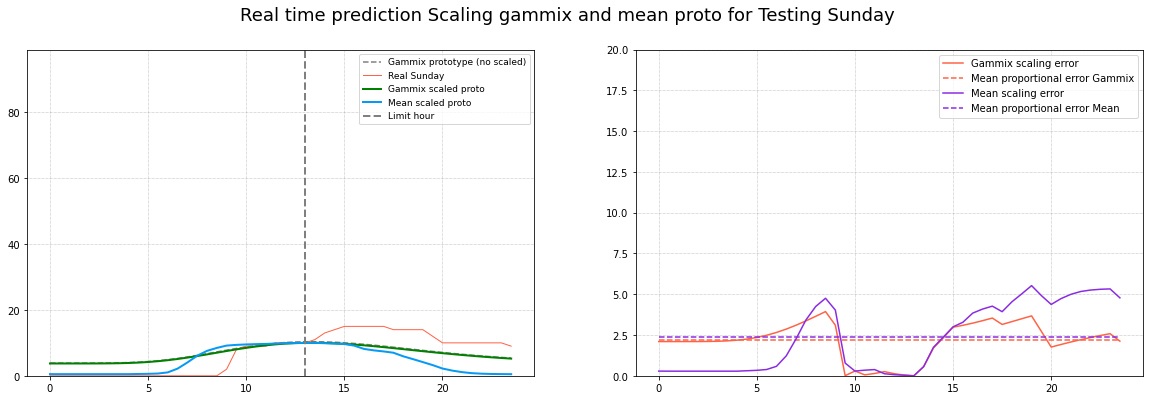

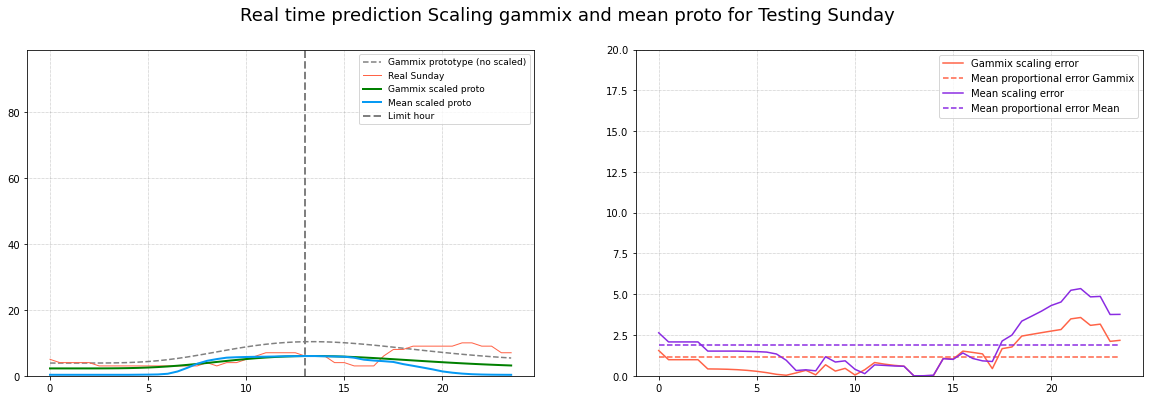

In [46]:
statistic_proto = hist_weekend_proto
gammix_proto = gam1_weekend
t_days = testing_sundays
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    ax[0].set_ylim([0,axis_ylim/2])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)

## NORMALIZATION

In [47]:
def Area_by_date(date):
    df = df_prediction_mean
    df_day = df[(df['Date'] == date)]
    day_occ = df_day['Occupancy_mod'].values
    Area = integrate.simps(day_occ)
    return Area


def df_normalization(occ, area):
    if area == 0:
        return occ
    return occ/area

def compute_min(date):
    df_day = df[(df['Date'] == date)]
    day_occ = df_day['Occupancy'].values
    return min(day_occ)


df_prediction_mean['Min_value'] = df_prediction_mean['Date'].apply(lambda x: compute_min(x))
df_mean_offset = df_prediction_mean.groupby(['Profile_3'], as_index=False).mean() 
df_mean_offset[['Profile_3','Min_value']]

friday_offset = df_mean_offset.iloc[0]['Min_value']
weekday_offset = df_mean_offset.iloc[1]['Min_value']
weekend_offset = df_mean_offset.iloc[2]['Min_value']

df_prediction_mean['Occupancy_mod'] = df_prediction_mean['Occupancy'] - df_prediction_mean['Min_value']



In [48]:
df_prediction_mean['Area'] = df_prediction_mean['Date'].apply(lambda x: Area_by_date(x))
df_prediction_mean['Normalized_occupancy'] = df_prediction_mean.apply(lambda x: df_normalization(x.Occupancy_mod, x.Area), axis=1)
df_normalized = df_prediction_mean[['Date', 'hour','MonthNumber', 'Normalized_occupancy', 'Weekday', 'Profile_3', 'Occupancy_mod', 'Area', 'Occupancy']].copy()


df_normalized

Date  hour MonthNumber  Normalized_occupancy   Weekday Profile_3  \
0     2020-01-07   0.0          01              0.000403   Tuesday   Weekday   
1     2020-01-07   0.5          01              0.000000   Tuesday   Weekday   
2     2020-01-07   1.0          01              0.000000   Tuesday   Weekday   
3     2020-01-07   1.5          01              0.000000   Tuesday   Weekday   
4     2020-01-07   2.0          01              0.000000   Tuesday   Weekday   
...          ...   ...         ...                   ...       ...       ...   
2923  2020-03-12  21.5          03              0.002061  Thursday   Weekday   
2924  2020-03-12  22.0          03              0.001237  Thursday   Weekday   
2925  2020-03-12  22.5          03              0.000412  Thursday   Weekday   
2926  2020-03-12  23.0          03              0.000412  Thursday   Weekday   
2927  2020-03-12  23.5          03              0.000000  Thursday   Weekday   

      Occupancy_mod         Area  Occupancy  
0                 1  2480.916667          2  
1                 0  2480.916667          1  
2                 0  2480.916667          1  
3                 0  2480.916667          1  
4                 0  2480.916667          1  
...             ...          ...        ...  
2923              5  2426.083333         16  
2924              3  2426.083333         14  
2925              1  2426.083333         12  
2926              1  2426.083333         12  
2927              0  2426.083333         11  

[2928 rows x 9 columns]

In [49]:
def split_data(df, n_test_weeks, limit_date = None, from_end=True): 
    if(limit_date != None):
        init_test = df[df['Date']==limit_date].index[0];
        end_test = df.shape[0]
        test_domain = range(init_test, end_test)
        test_domain = list(test_domain)

    else:
        if(from_end == True):
            end_test = df.shape[0]
            week_domain = n_test_weeks*336
            init_test = end_test-week_domain
            test_domain = range(init_test, end_test)
            test_domain = list(test_domain)
            
        elif(from_end == False):
            week_domain = n_test_weeks*336
            init_test = 0
            end_test = week_domain
            test_domain = range(0,week_domain)
            test_domain = list(test_domain)
            
    test_df = df[init_test:end_test]
    training_df = df.drop(test_domain)
    return training_df, test_df

In [50]:
df_training, df_testing = split_data(df_normalized, 3)
df_testing

Date  hour MonthNumber  Normalized_occupancy   Weekday Profile_3  \
1920  2020-02-18   0.0          02              0.000000   Tuesday   Weekday   
1921  2020-02-18   0.5          02              0.000000   Tuesday   Weekday   
1922  2020-02-18   1.0          02              0.000000   Tuesday   Weekday   
1923  2020-02-18   1.5          02              0.000000   Tuesday   Weekday   
1924  2020-02-18   2.0          02              0.000000   Tuesday   Weekday   
...          ...   ...         ...                   ...       ...       ...   
2923  2020-03-12  21.5          03              0.002061  Thursday   Weekday   
2924  2020-03-12  22.0          03              0.001237  Thursday   Weekday   
2925  2020-03-12  22.5          03              0.000412  Thursday   Weekday   
2926  2020-03-12  23.0          03              0.000412  Thursday   Weekday   
2927  2020-03-12  23.5          03              0.000000  Thursday   Weekday   

      Occupancy_mod         Area  Occupancy  
1920              0  2299.000000          0  
1921              0  2299.000000          0  
1922              0  2299.000000          0  
1923              0  2299.000000          0  
1924              0  2299.000000          0  
...             ...          ...        ...  
2923              5  2426.083333         16  
2924              3  2426.083333         14  
2925              1  2426.083333         12  
2926              1  2426.083333         12  
2927              0  2426.083333         11  

[1008 rows x 9 columns]

In [51]:
df_training['Area'] = df_training['Date'].apply(lambda x: Area_by_date(x))
df_training

df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)


# df_normalized

Weekday area:  2686.0615942028985
Friday area:  2170.799999999998
Weekend area:  163.30555555555694


In [52]:
def get_days_normalized(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Normalized_occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
    return days

def get_days_of_protos_normalized(proto_name, df_):
    data_temp = df_[df_['Profile_3'] == proto_name] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Normalized_occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days

In [53]:
# ------------------------ NEW TESTING DATA -----------------------------
# these variables are arrays of days
testing_mondays_norm    = get_days_normalized("Monday", df_testing)
testing_tuesdays_norm   = get_days_normalized("Tuesday", df_testing)
testing_wednesdays_norm = get_days_normalized("Wednesday", df_testing)
testing_thursdays_norm  = get_days_normalized("Thursday", df_testing)
testing_fridays_norm    = get_days_normalized("Friday", df_testing)
testing_saturdays_norm  = get_days_normalized("Saturday", df_testing)
testing_sundays_norm    = get_days_normalized("Sunday", df_testing)

testing_mondays    = get_days("Monday", df_testing)
testing_tuesdays   = get_days("Tuesday", df_testing)
testing_wednesdays = get_days("Wednesday", df_testing)
testing_thursdays  = get_days("Thursday", df_testing)
testing_fridays    = get_days("Friday", df_testing)
testing_saturdays  = get_days("Saturday", df_testing)
testing_sundays    = get_days("Sunday", df_testing)

In [54]:
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
# for ii in range(len(training_weekdays_norm)):
#     plt.plot(time,training_weekdays_norm[ii])

In [57]:
from scipy.special import gamma, factorial
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def mix_gam_dis(x , w1 ,b1 ,a1, w2, b2, a2):
    wave1 = w1*((b1**a1)*((x)**(a1-1))*np.exp(-b1*(x)))/(gamma(a1)); 
    wave2 = w2*((b2**a2)*((x)**(a2-1))*np.exp(-b2*(x)))/(gamma(a2))
    total_wave =  wave1 + wave2    
    return total_wave

def gam(x,w,b,a):
     return w*((b**a)*((x)**(a-1))*np.exp(-b*(x)))/(gamma(a))
    
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekends_norm = training_weekends_norm[:-1]

time = np.linspace(0,23.5,48)
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)


def gammix_minimization_weekday(params):
    w1 = params[0]
    b1 = params[1]
    a1 = params[2]
    w2 = params[3]
    b2 = params[4]
    a2 = params[5]
    error = 0
    
    for ii in range(0,wd_length):
        day = training_weekdays_norm[ii]
        error += mean_squared_error(mix_gam_dis(time, w1, b1, a1, w2, b2, a2), day)
    return error


def gammix_minimization_friday(params):
    w1 = params[0]
    b1 = params[1]
    a1 = params[2]
    w2 = params[3]
    b2 = params[4]
    a2 = params[5]
    error = 0
    
    for ii in range(0,f_length):
        day = training_fridays_norm[ii]
#         print('MSE: ', mean_squared_error(mix_gam_dis(time, h, w1, b1, a1, w2, b2, a2), day))
        error += mean_squared_error(mix_gam_dis(time, w1, b1, a1, w2, b2, a2), day)
    return error


def gammix_minimization_weekend(params):
    w1 = params[0]
    b1 = params[1]
    a1 = params[2]
    error = 0
    
    for ii in range(0,we_length):
        if ii == 5:
            continue
        else:
            day = training_weekends_norm[ii]
            error += mean_squared_error(gam(time,w1, b1, a1), day)
    return error


x0=np.array([0.25029473,  1.48878967, 15.04758968,  0.25324048,  1.58598843,
       25.15505399])
# ************************** WEEKDAYS *********************************
res_weekday = minimize(gammix_minimization_weekday, x0, method='Nelder-Mead', tol=0.01)

opt_params = res_weekday.x;
w1 = opt_params[0];
b1 = opt_params[1];
a1 = opt_params[2];
w2 = opt_params[3];
b2 = opt_params[4];
a2 = opt_params[5];

gammix_weekday_n = mix_gam_dis(time, w1, b1, a1, w2, b2, a2)
gam1_weekday_n = gam(time, w1, b1, a1)
gam2_weekday_n = gam(time, w2, b2, a2)

x0=np.array([4.16924399e-02, 6.10882339e+00, 4.97050917e+01, 4.65556528e-01,
       7.63899546e-01, 1.02917427e+01])
# ************************** FRIDAY *********************************
res_friday = minimize(gammix_minimization_friday, x0, method='Nelder-Mead', tol=0.01)

opt_params = res_friday.x;
w1 = opt_params[0];
b1 = opt_params[1];
a1 = opt_params[2];
w2 = opt_params[3];
b2 = opt_params[4];
a2 = opt_params[5];

gammix_friday_n = mix_gam_dis(time, w1, b1, a1, w2, b2, a2)
gam1_friday_n = gam(time, w1, b1, a1)
gam2_friday_n = gam(time, w2, b2, a2)

x1=np.array([0.41243049,  0.64970176, 10.93987881])
# ************************** WEEKEND *********************************
res_weekend = minimize(gammix_minimization_weekend, x1, method='Nelder-Mead', tol=0.01)

opt_params = res_weekend.x;
w1 = opt_params[0];
b1 = opt_params[1];
a1 = opt_params[2];
 
gam1_weekend_n = gam(time, w1, b1, a1)

In [58]:
opt_params

array([0.44063286, 0.34976012, 5.41990686])

Text(0, 0.5, 'Probability')

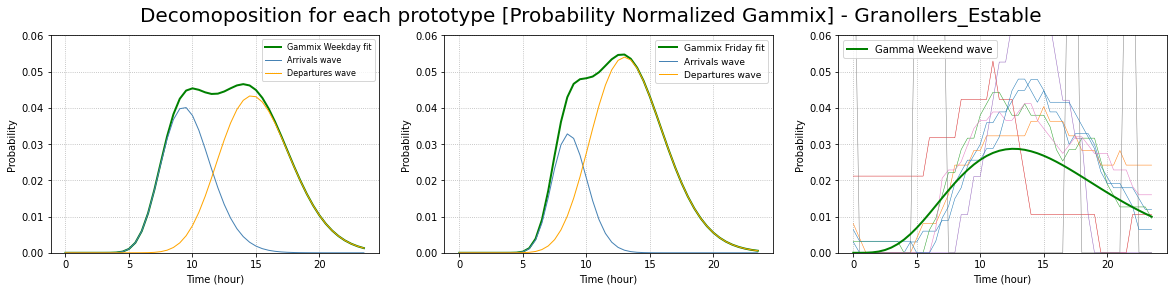

In [59]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [Probability Normalized Gammix] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time, gammix_weekday_n, linewidth=2, color= 'green', label='Gammix Weekday fit')
ax[0].plot(time, gam1_weekday_n, linewidth=1, color='steelblue', label='Arrivals wave')
ax[0].plot(time, gam2_weekday_n, linewidth=1, color='orange', label='Departures wave')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time, gammix_friday_n, linewidth=2, color= 'green', label='Gammix Friday fit')
ax[1].plot(time, gam1_friday_n, linewidth=1, color='steelblue', label='Arrivals wave')
ax[1].plot(time, gam2_friday_n, linewidth=1, color='orange', label='Departures wave')
ax[1].set_ylim([0,0.06])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

for ii in range(len(training_weekends_norm)):
     ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time, gam1_weekend_n, linewidth=2, color='green', label='Gamma Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability')
# ax[2].set_yticks([0,0.005,0.01])
# ax[2].set_yticks(["0","0.05","0.1"])


Text(0, 0.5, 'Probability')

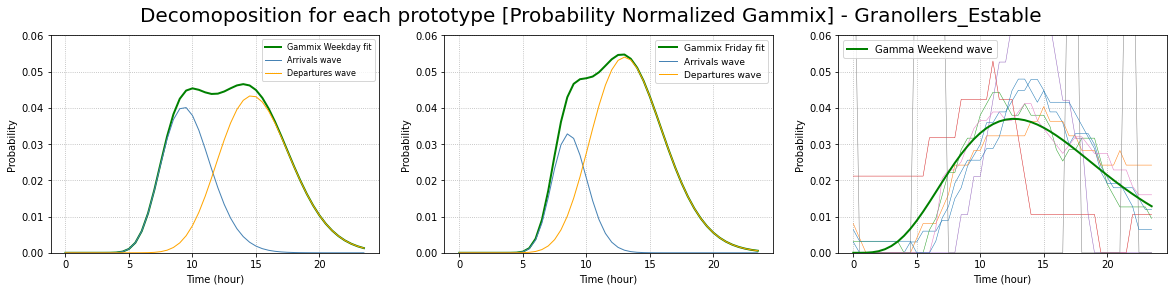

In [60]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [Probability Normalized Gammix] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time, gammix_weekday_n, linewidth=2, color= 'green', label='Gammix Weekday fit')
ax[0].plot(time, gam1_weekday_n, linewidth=1, color='steelblue', label='Arrivals wave')
ax[0].plot(time, gam2_weekday_n, linewidth=1, color='orange', label='Departures wave')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time, gammix_friday_n, linewidth=2, color= 'green', label='Gammix Friday fit')
ax[1].plot(time, gam1_friday_n, linewidth=1, color='steelblue', label='Arrivals wave')
ax[1].plot(time, gam2_friday_n, linewidth=1, color='orange', label='Departures wave')
ax[1].set_ylim([0,0.06])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')


Area = integrate.simps(gam1_weekend_n) 
gam1_weekend_n = gam1_weekend_n/Area

for ii in range(len(training_weekends_norm)):
     ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time, gam1_weekend_n, linewidth=2, color='green', label='Gamma Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability')
# ax[2].set_yticks([0,0.005,0.01])
# ax[2].set_yticks(["0","0.05","0.1"])

In [61]:
sum(gam1_weekend_n)

1.0063303999388138

In [62]:
#**************************************WEEKDAY************************************
opt_params = res_weekday.x;
w1 = opt_params[0];
b1 = opt_params[1];
a1 = opt_params[2];
w2 = opt_params[3];
b2 = opt_params[4];
a2 = opt_params[5];

gammix_weekday = gammix_weekday_n*weekday_area + weekday_offset
gam1_weekday = gam1_weekday_n*weekday_area + weekday_offset
gam2_weekday = gam2_weekday_n*weekday_area + weekday_offset
#**************************************FRIDAY************************************
opt_params = res_friday.x;
w1 = opt_params[0];
b1 = opt_params[1];
a1 = opt_params[2];
w2 = opt_params[3];
b2 = opt_params[4];
a2 = opt_params[5];

gammix_friday = gammix_friday_n*friday_area + friday_offset
gam1_friday = gam1_friday_n*friday_area + friday_offset
gam2_friday = gam2_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
opt_params = res_weekend.x;
w1 = opt_params[0];
b1 = opt_params[1];
a1 = opt_params[2];

gam1_weekend = gam1_weekend_n*weekend_area + weekend_offset 


Text(0, 0.5, 'Probability')

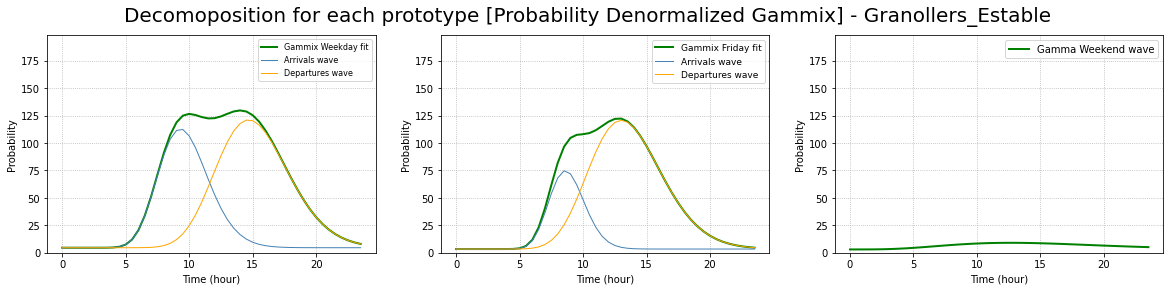

In [63]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [Probability Denormalized Gammix] - ' + current_parking , fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time, gammix_weekday, linewidth=2, color= 'green', label='Gammix Weekday fit')
ax[0].plot(time, gam1_weekday, linewidth=1, color='steelblue', label='Arrivals wave')
ax[0].plot(time, gam2_weekday, linewidth=1, color='orange', label='Departures wave')
ax[0].set_ylim([0,axis_ylim])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time, gammix_friday, linewidth=2, color= 'green', label='Gammix Friday fit')
ax[1].plot(time, gam1_friday, linewidth=1, color='steelblue', label='Arrivals wave')
ax[1].plot(time, gam2_friday, linewidth=1, color='orange', label='Departures wave')
ax[1].set_ylim([0,axis_ylim])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends_norm)):
#     ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time, gam1_weekend, linewidth=2, color='green', label='Gamma Weekend wave')
ax[2].set_ylim([0,axis_ylim])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability')
# ax[2].set_yticks([0,0.005,0.01])
# ax[2].set_yticks(["0","0.05","0.1"])

### Comparing normalized gammix fitted prototype with testing data

In [64]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=2.5, linestyle='dashed', label= proto_name + ' prediction')
    ax[xx,yy].legend()
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=0.75, label='Testing ' + day )
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(-2,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)')
    ax[xx,yy].set_ylabel('Occupancy')


### Denormalization / Rescaling

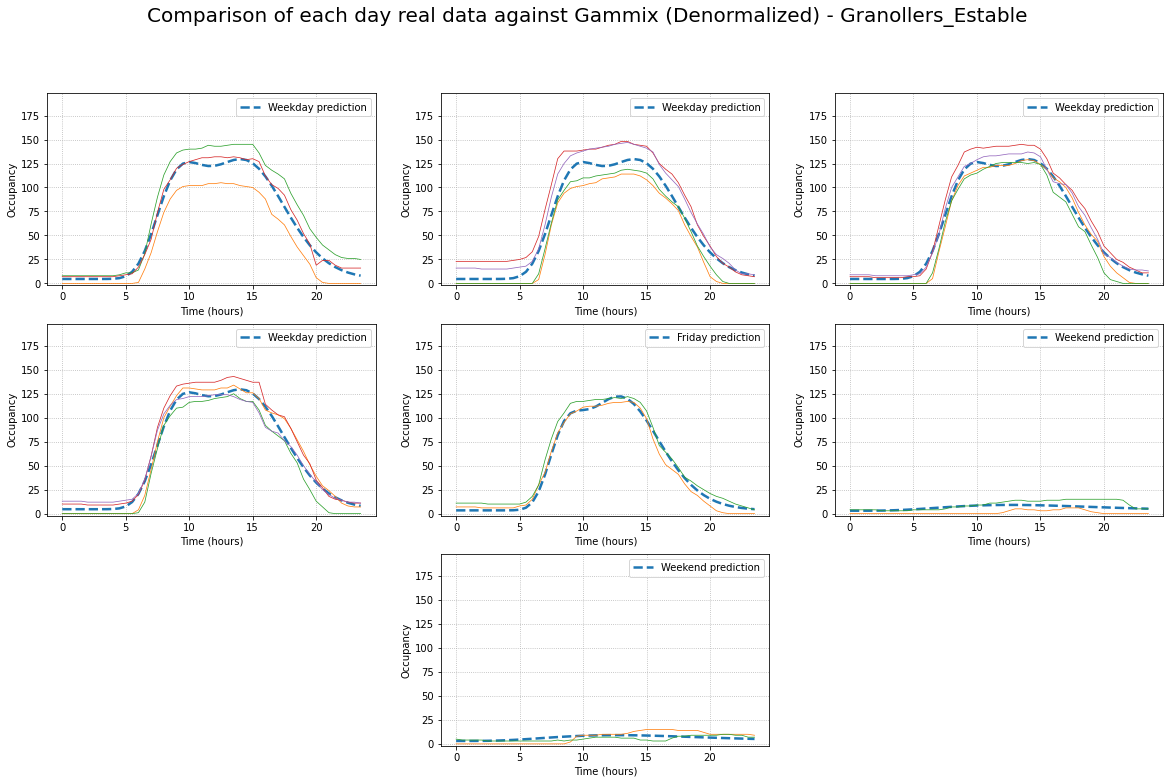

In [65]:
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Comparison of each day real data against Gammix (Denormalized) - ' + current_parking, fontsize=20)

gammix_weekday = gammix_weekday_n*weekday_area + weekday_offset
gammix_friday = gammix_friday_n*friday_area + friday_offset
gam1_weekend = gam1_weekend_n*weekend_area + weekend_offset 

subplot_training(fig, ax, 0, 0, gammix_weekday, testing_mondays, 'Monday', 'Weekday')
subplot_training(fig, ax, 0, 1, gammix_weekday, testing_tuesdays, 'Tuesday', 'Weekday')
subplot_training(fig, ax, 0, 2, gammix_weekday, testing_wednesdays, 'Wednesday', 'Weekday')
subplot_training(fig, ax, 1, 0, gammix_weekday, testing_thursdays, 'Thursday', 'Weekday')
subplot_training(fig, ax, 1, 1, gammix_friday, testing_fridays, 'Friday', 'Friday')
subplot_training(fig, ax, 1, 2, gam1_weekend, testing_saturdays, 'Saturday', 'Weekend')
subplot_training(fig, ax, 2, 1, gam1_weekend, testing_sundays, 'Sunday', 'Weekend')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)

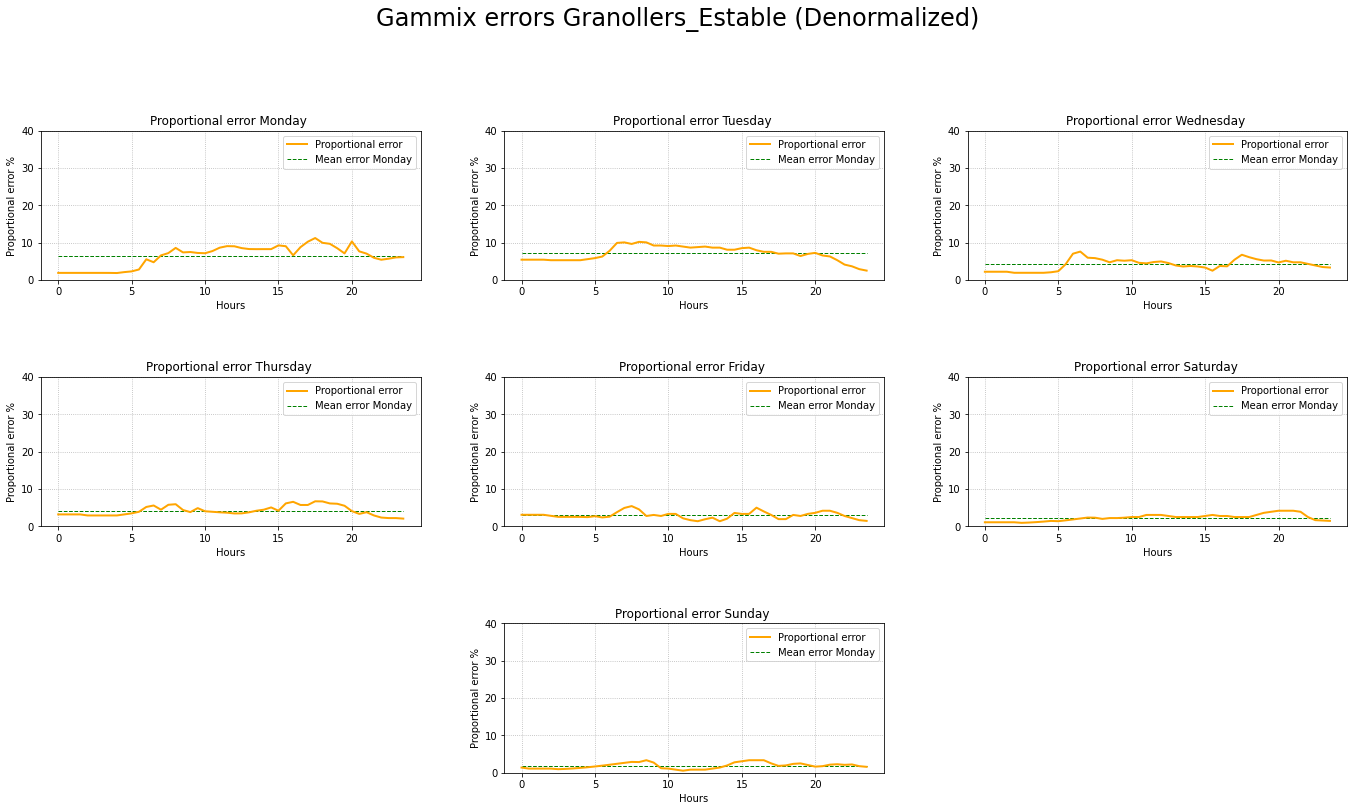

In [66]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_gammix = compute_testing_prop_error(testing_mondays, gammix_weekday)
error_tuesday_gammix = compute_testing_prop_error(testing_tuesdays, gammix_weekday)
error_wednesday_gammix = compute_testing_prop_error(testing_wednesdays, gammix_weekday)
error_thursday_gammix = compute_testing_prop_error(testing_thursdays, gammix_weekday)
error_friday_gammix = compute_testing_prop_error(testing_fridays, gammix_friday)
error_saturday_gammix = compute_testing_prop_error(testing_saturdays, gam1_weekend)
error_sunday_gammix = compute_testing_prop_error(testing_sundays, gam1_weekend)

def subplotGammixErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="orange", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='green', label='Mean error Monday')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].legend(loc='upper left', fontsize=9)
    ax[axx,axy].set_ylabel('Proportional error %')
    ax[axx,axy].set_xlabel('Hours')
    ax[axx,axy].set_title(title)
    ax[axx,axy].set_ylim((0,40))
    ax[axx,axy].legend()
    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Gammix errors ' + current_parking + ' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 0, time, error_monday_gammix, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 1, time, error_tuesday_gammix, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 2, time, error_wednesday_gammix, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 0, time, error_thursday_gammix, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 1, time, error_friday_gammix, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 2, time, error_saturday_gammix, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_gammix)]*len(time)
subplotGammixErr(fig, ax, 2, 1, time, error_sunday_gammix, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in axs.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)

### V. Gammix: Real time prediction by SCALING

As in real time some partial information is already known, we can take advantage of this by using this already known information to scale the Gammix output and make it more similar to the day that is left to be predicted. 

In [67]:
# Plotting methods to reduce cell dimension

def real_timing_predition(fig, ax, axx, day, gammix_proto, real_day, scaled_proto, Prototype):
    fig.suptitle('Real time prediction Scaling gammix and mean proto for Testing ' + day, fontsize='18')
    ax[axx].plot(time, gammix_proto,'--',color='grey', label='Gammix prototype (no scaled)')
    ax[axx].plot(time, real_day.values, color='tomato', linewidth=1, label='Real ' + day)
    ax[axx].plot(time, scaled_proto, color='green', linewidth=2, label='Gammix scaled proto')
    ax[axx].plot(time, Prototype, color='#069AF3', linewidth=2, label='Mean scaled proto')
    ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='Limit hour ')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend(fontsize=9)

def errors_plotting(fig, ax, axx, scaled_proto, Prototype, real_day, day):
    #Computing Errors
    gammix_scaled_error = (np.absolute((np.array(scaled_proto) - np.array(real_day.values)))/max_value)*100
    mean_scaled_error = (np.absolute((np.array(Prototype) - np.array(real_day.values)))/max_value)*100

    gammix_s_error_mean = [np.mean(gammix_scaled_error)]*len(gammix_scaled_error)
    mean_s_error_mean = [np.mean(mean_scaled_error)]*len(mean_scaled_error)

    #Second plot
    ax[axx].plot(time, gammix_scaled_error, color='tomato', label='Gammix scaling error')
    ax[axx].plot(time,gammix_s_error_mean, '--',color='tomato', label='Mean proportional error Gammix')
    ax[axx].plot(time,mean_scaled_error, color='blueviolet', label='Mean scaling error')
    ax[axx].plot(time,mean_s_error_mean, '--',color='blueviolet', label='Mean proportional error Mean')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend()
    ax[axx].set_ylim([0,20])

    print('Real ' + day + ' scaled prtotype error: ', round(100*mean_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled Gammix error: ', round(100*gammix_s_error_mean[0])/100, '%')

def get_scaling_factor(limit_hour, test_day, proto):
    if limit_hour < 6:
        return 1
    index = limit_hour*2
    current_real_data = test_day.values[index]
    proto_value = proto[index]
    scaling = current_real_data/proto_value
    return scaling

#### MONDAY

Real Monday scaled prtotype error:  3.4 %
Real Monday scaled Gammix error:  3.6 %
Real Monday scaled prtotype error:  3.21 %
Real Monday scaled Gammix error:  3.48 %
Real Monday scaled prtotype error:  1.65 %
Real Monday scaled Gammix error:  1.94 %


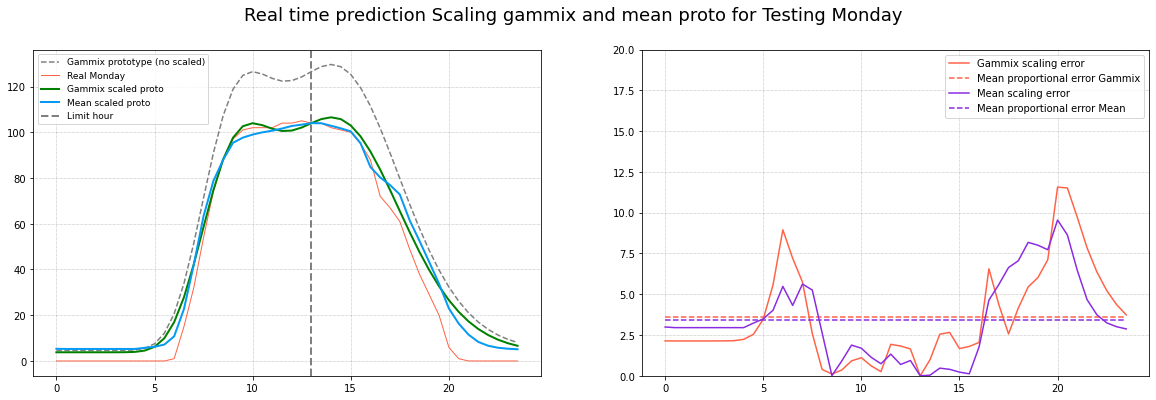

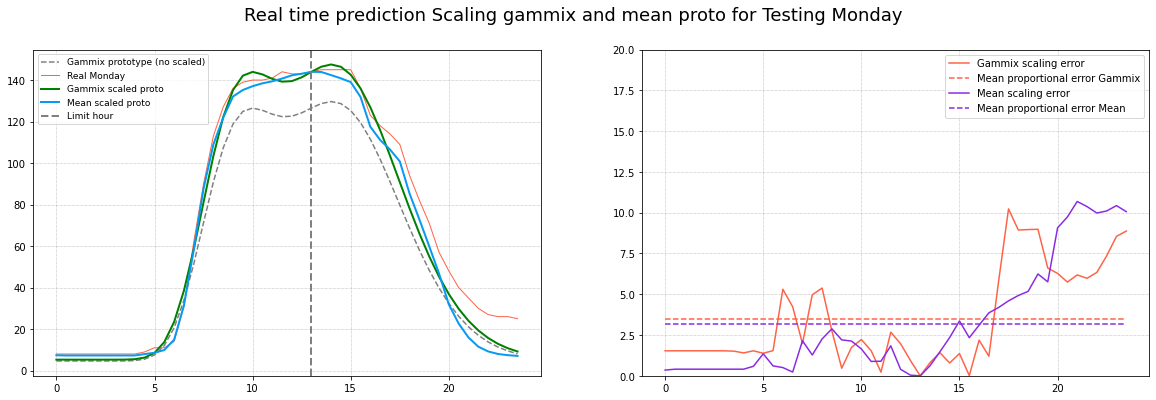

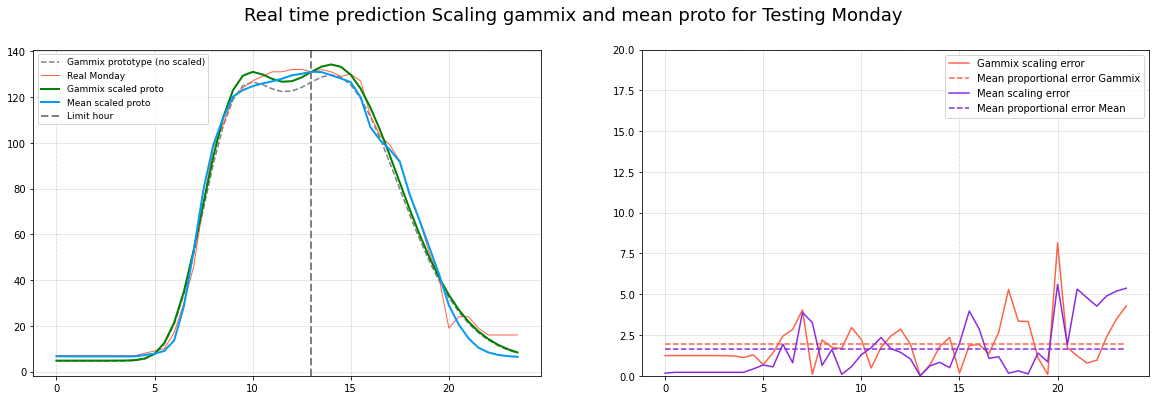

In [68]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_mondays
limit_hour = 13
day = 'Monday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

#### TUESDAY

Real Tuesday scaled prtotype error:  3.57 %
Real Tuesday scaled Gammix error:  4.13 %
Real Tuesday scaled prtotype error:  2.99 %
Real Tuesday scaled Gammix error:  3.58 %
Real Tuesday scaled prtotype error:  4.15 %
Real Tuesday scaled Gammix error:  5.03 %
Real Tuesday scaled prtotype error:  2.17 %
Real Tuesday scaled Gammix error:  2.8 %


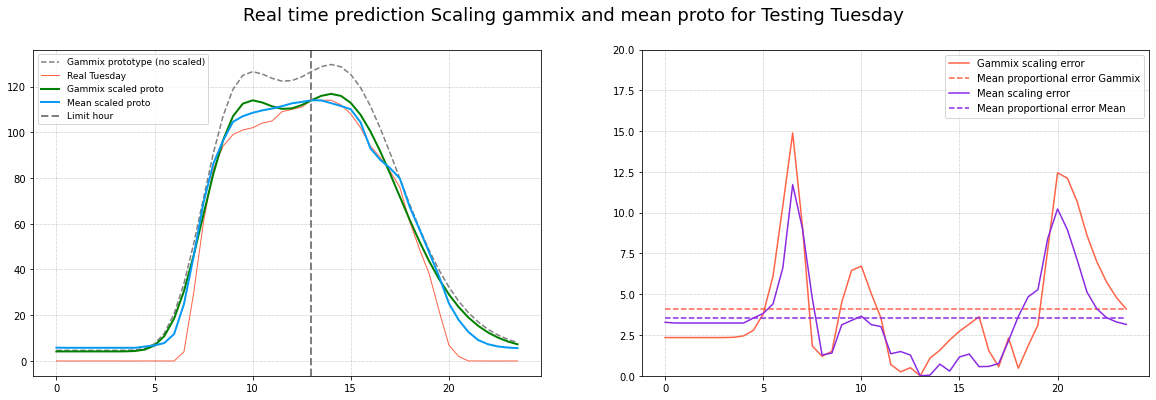

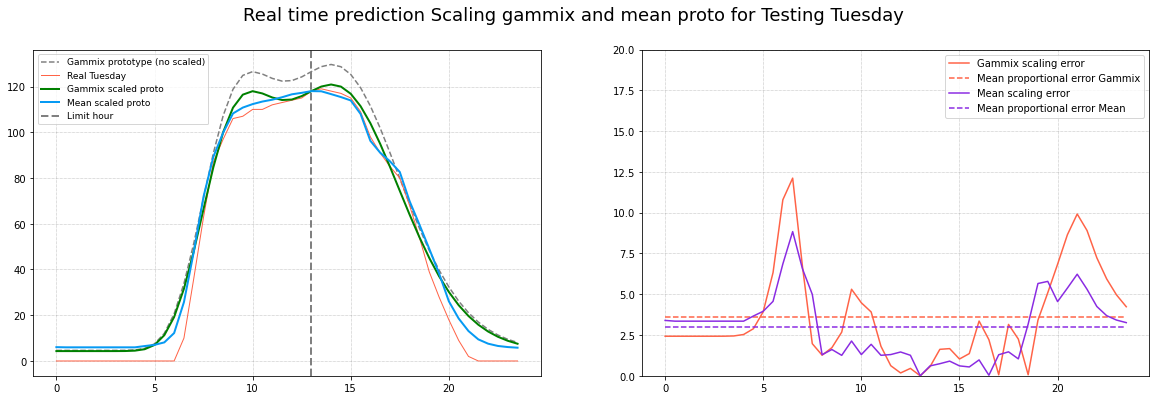

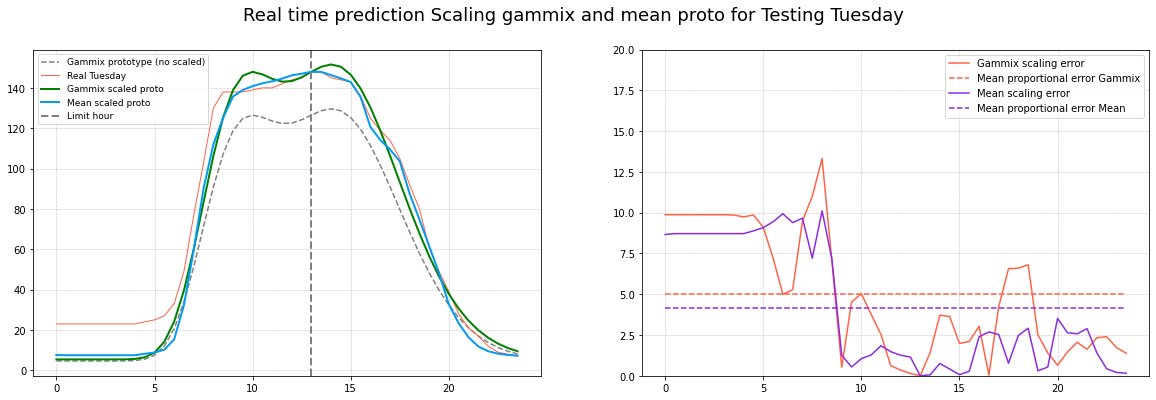

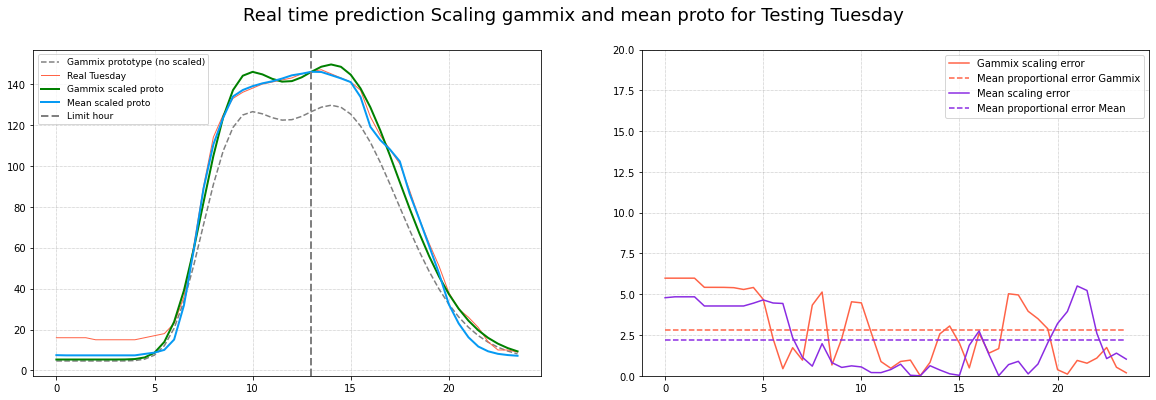

In [69]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_tuesdays
limit_hour = 13
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### WEDNESDAY

Real Wednesday scaled prtotype error:  3.07 %
Real Wednesday scaled Gammix error:  3.54 %
Real Wednesday scaled prtotype error:  4.22 %
Real Wednesday scaled Gammix error:  4.73 %
Real Wednesday scaled prtotype error:  1.61 %
Real Wednesday scaled Gammix error:  1.84 %
Real Wednesday scaled prtotype error:  1.44 %
Real Wednesday scaled Gammix error:  2.08 %


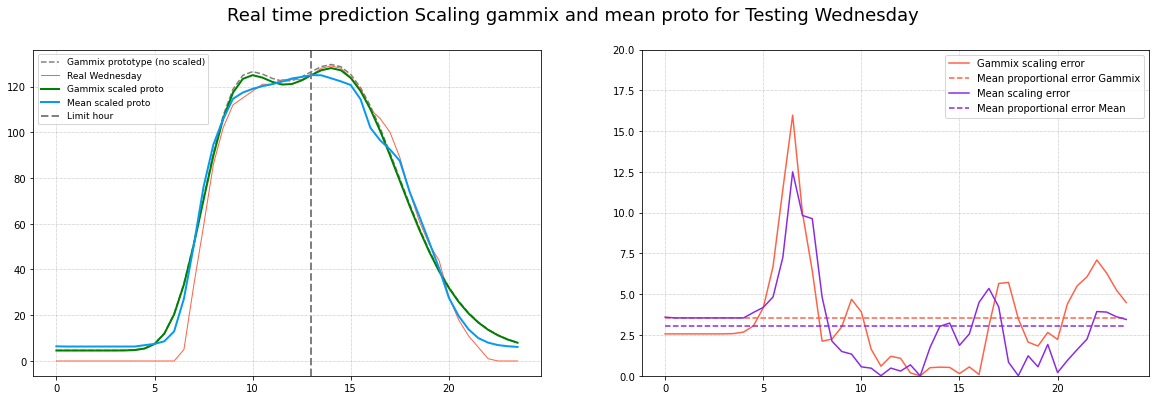

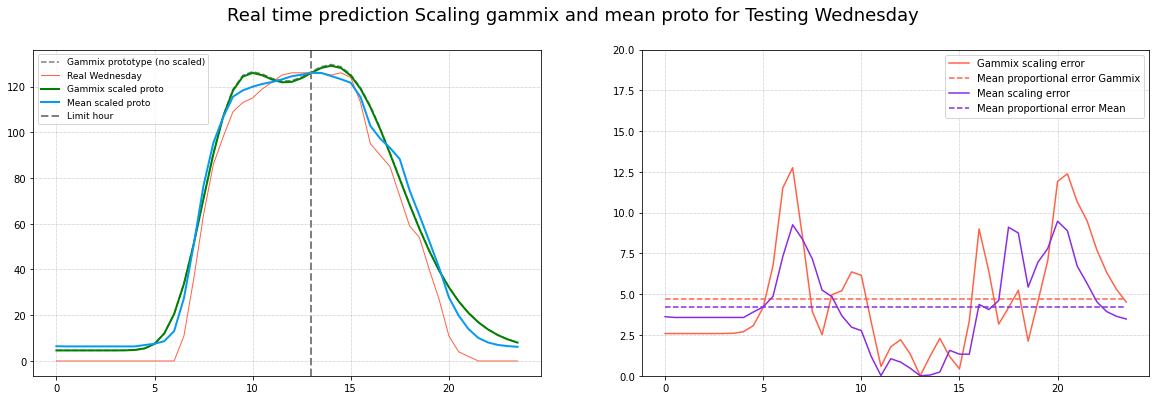

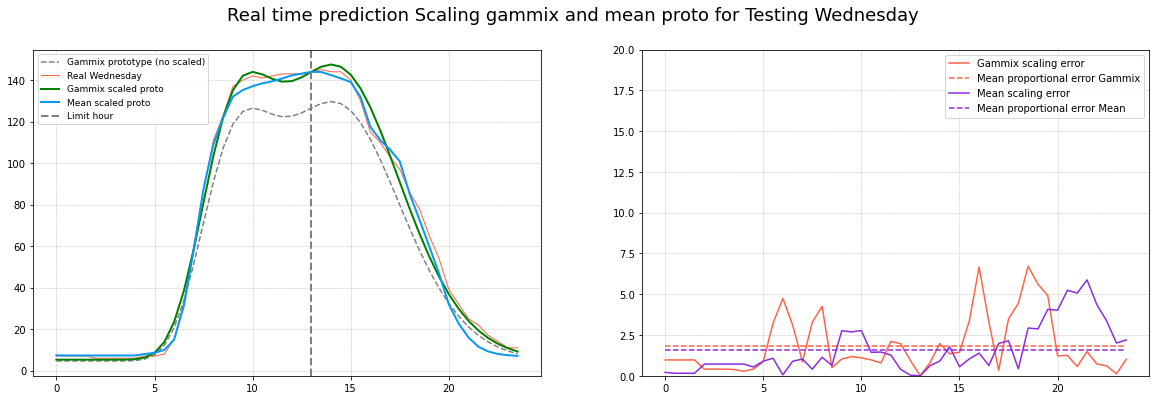

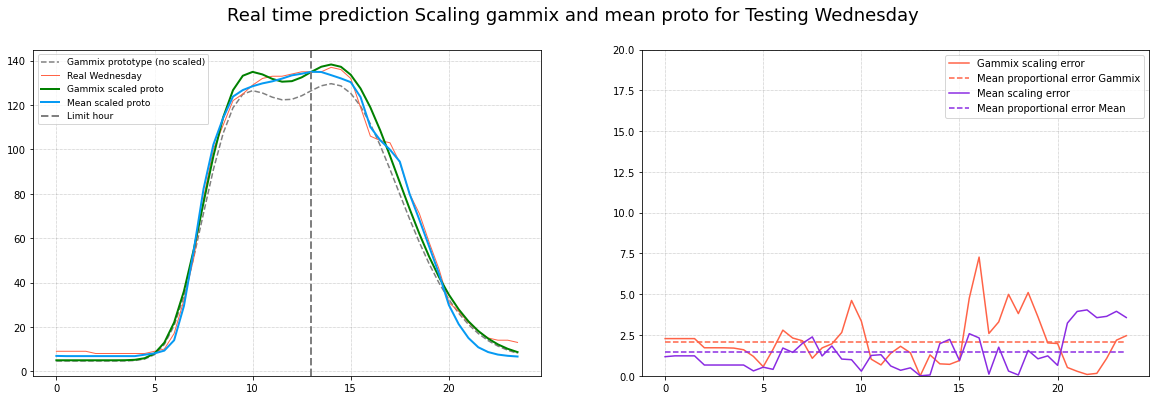

In [70]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_wednesdays
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### THURSDAY

Real Thursday scaled prtotype error:  2.9 %
Real Thursday scaled Gammix error:  3.06 %
Real Thursday scaled prtotype error:  3.46 %
Real Thursday scaled Gammix error:  4.1 %
Real Thursday scaled prtotype error:  1.47 %
Real Thursday scaled Gammix error:  2.26 %
Real Thursday scaled prtotype error:  3.12 %
Real Thursday scaled Gammix error:  3.07 %


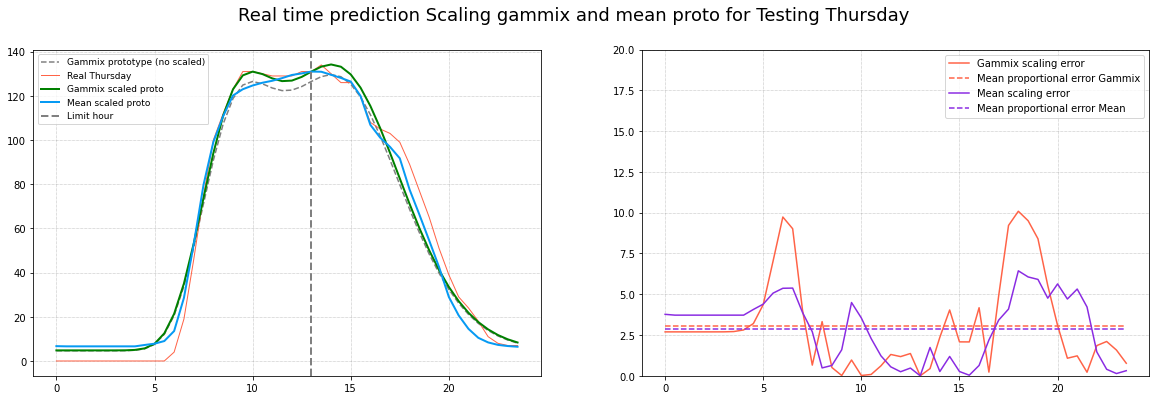

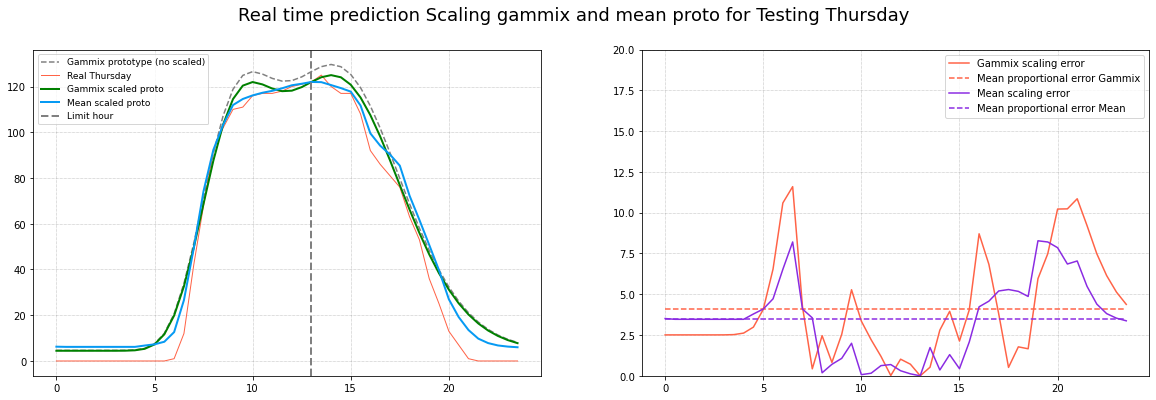

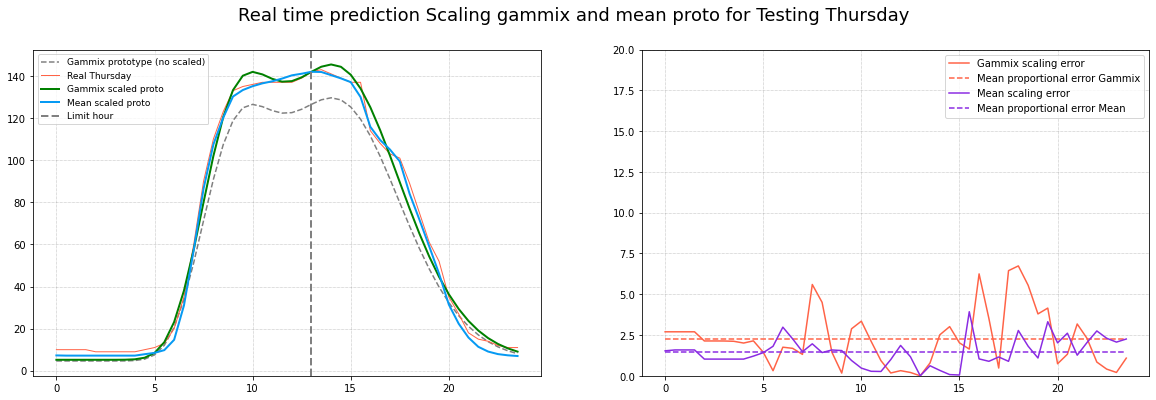

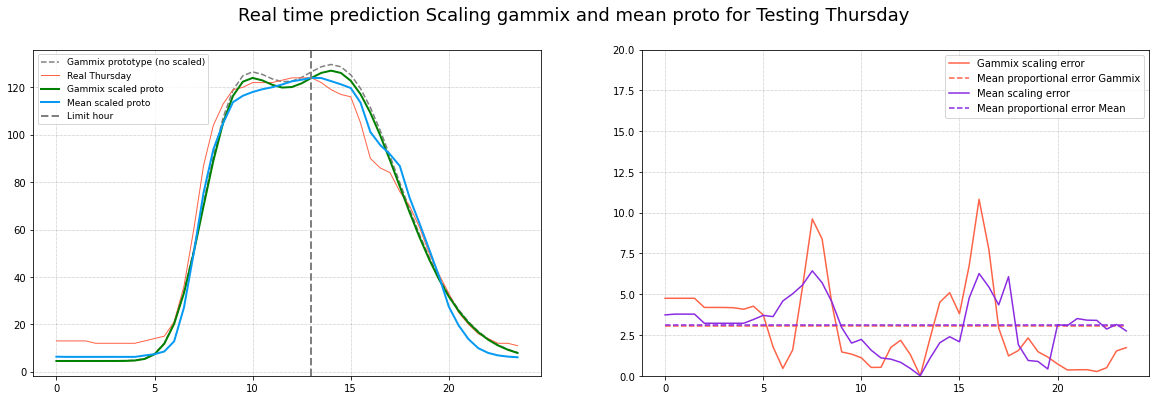

In [71]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_thursdays
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### FRIDAY

Real Friday scaled prtotype error:  5.2 %
Real Friday scaled Gammix error:  2.8 %
Real Friday scaled prtotype error:  4.36 %
Real Friday scaled Gammix error:  3.73 %


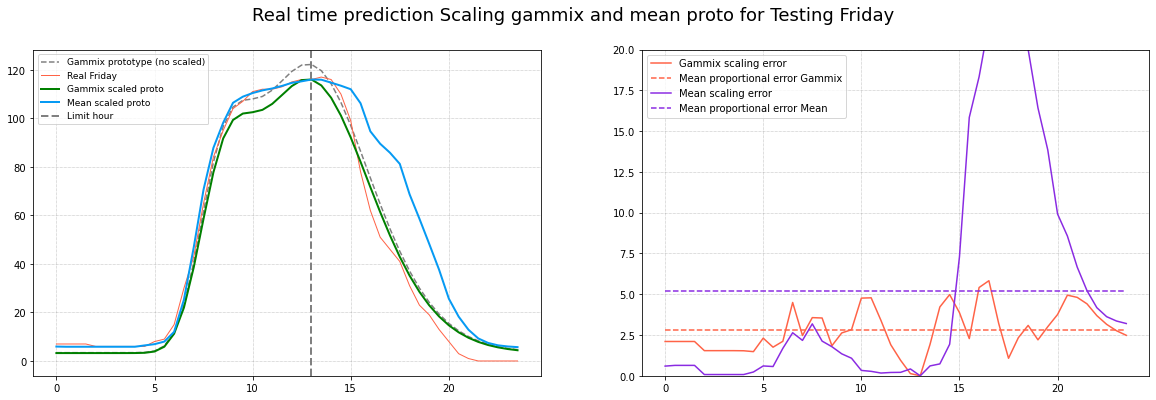

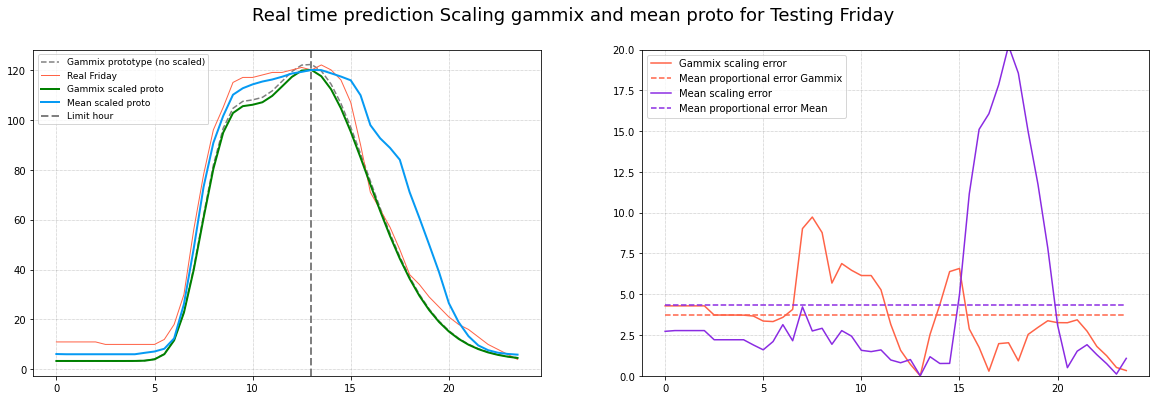

In [72]:
statistic_proto = hist_friday_proto
gammix_proto = gammix_friday
t_days = testing_fridays
limit_hour = 13
day = 'Friday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### WEEKEND

### SATURDAY

Real Saturday scaled prtotype error:  0.84 %
Real Saturday scaled Gammix error:  1.42 %
Real Saturday scaled prtotype error:  2.38 %
Real Saturday scaled Gammix error:  1.58 %


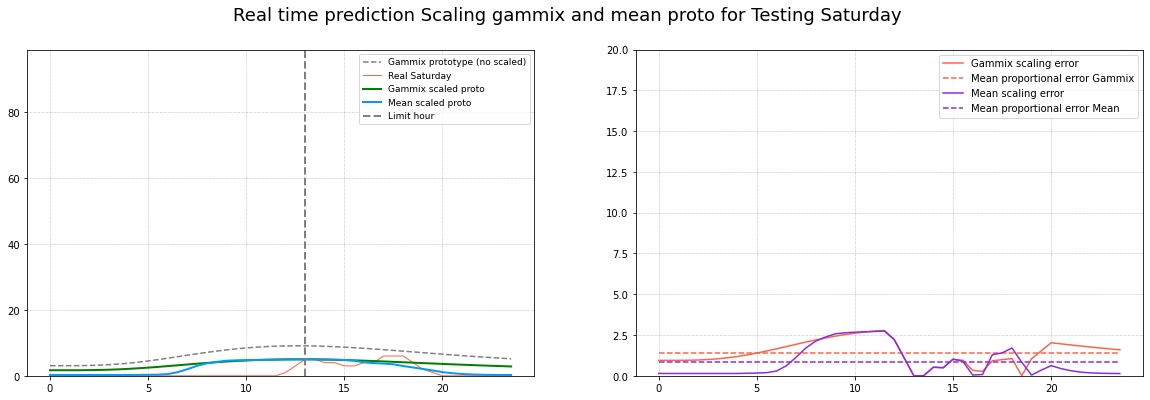

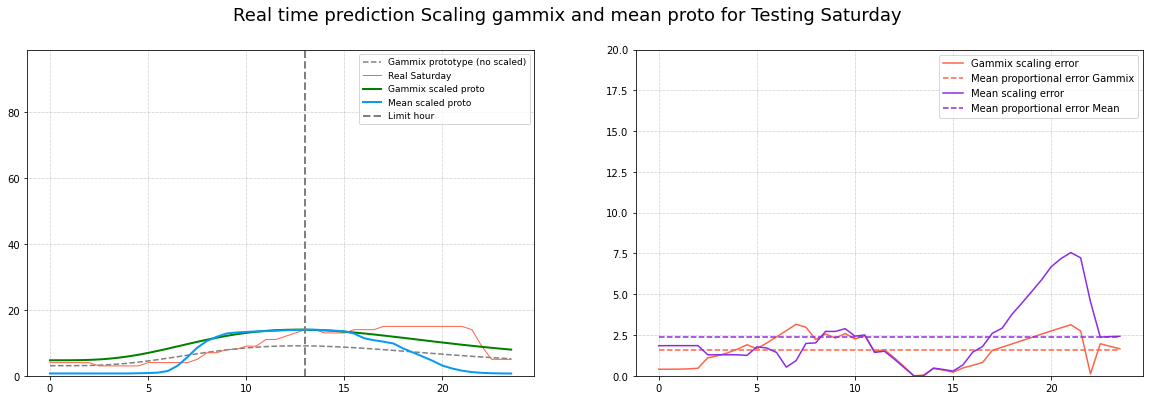

In [73]:
statistic_proto = hist_weekend_proto
gammix_proto = gam1_weekend
t_days = testing_saturdays
limit_hour = 13
day = 'Saturday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    ax[0].set_ylim([0,axis_ylim/2])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)
    

### SUNDAY

Real Sunday scaled prtotype error:  2.36 %
Real Sunday scaled Gammix error:  2.26 %
Real Sunday scaled prtotype error:  1.86 %
Real Sunday scaled Gammix error:  1.15 %


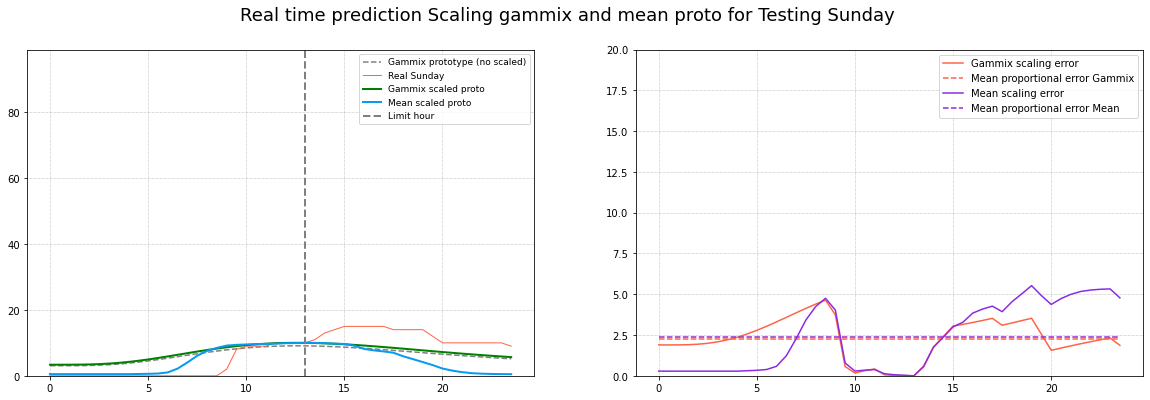

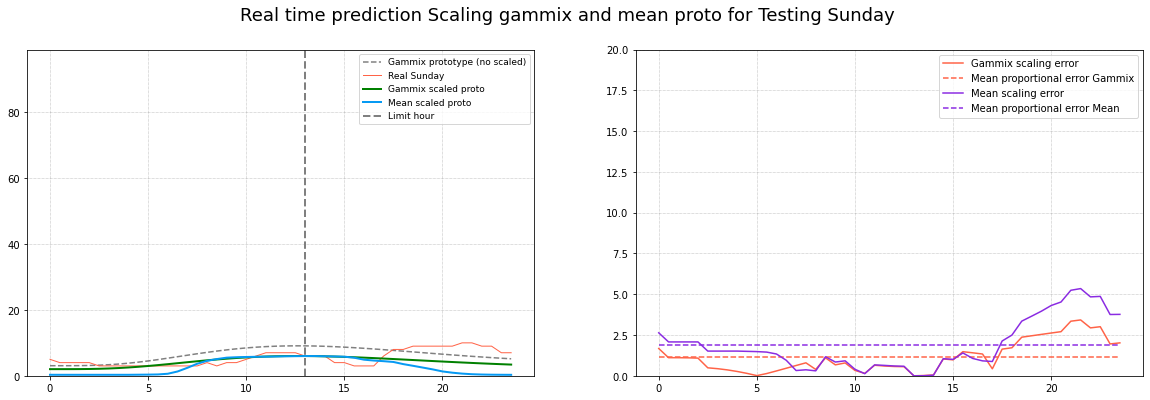

In [74]:
statistic_proto = hist_weekend_proto
gammix_proto = gam1_weekend
t_days = testing_sundays
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto)
    ax[0].set_ylim([0,axis_ylim/2])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day)

### Error with CDF

In [75]:
def generate_cumulative(day):
    cumulative=[]
    for ii in range(len(day)):
        cumulative.append(sum(day[:ii]))
    return cumulative

## WEEKDAYS

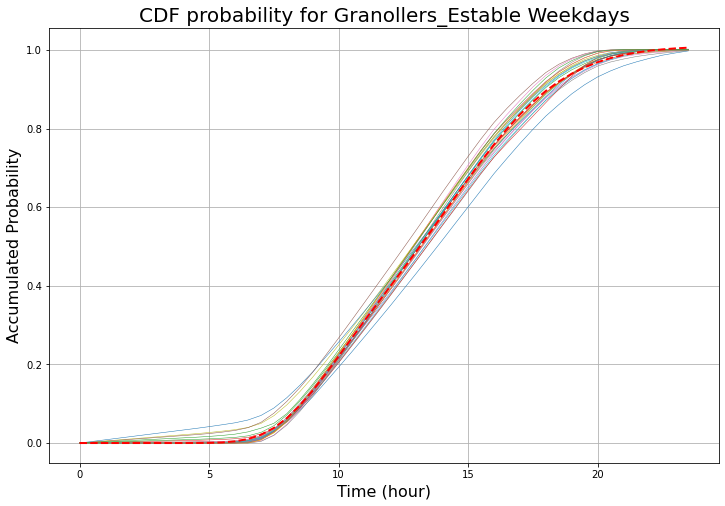

In [76]:
training_weekdays_cdf = []
fig = plt.figure(figsize=(12,8))

for i in range(0, len(training_weekdays_norm)):
    t = generate_cumulative(training_weekdays_norm[i].values)
    training_weekdays_cdf.append(t)
    plt.plot(time, t, linewidth=0.5)

gammix_weekday_cdf = generate_cumulative(gammix_weekday_n)
plt.title('CDF probability for ' + current_parking + ' Weekdays', fontsize = 20)
plt.plot(time, gammix_weekday_cdf, linewidth=2, color='red', linestyle='dashed')
plt.xlabel('Time (hour)', fontsize = 16)
plt.ylabel('Accumulated Probability', fontsize = 16)
plt.grid()

# training_weekdays_cdf
def cdf_error(proto, days):
    er=0
    for i in range(0,len(days)):
        er += np.abs(proto-days[i])
    return er/len(days)

# error = cdf_error()

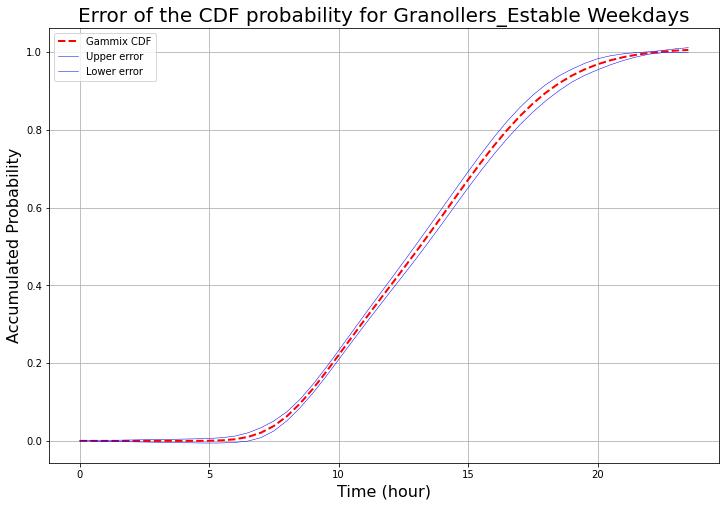

In [77]:
#Performance of the errors

cummulative_error_weekdays = [];
error = np.zeros(len(gammix_weekday_cdf));
for current_day in training_weekdays_cdf:
    current_error = abs(np.array(current_day)-np.array(gammix_weekday_cdf))
    cummulative_error_weekdays.append(current_error)
    error += np.array(current_error)
error = error/len(training_weekdays_cdf)


gammix_weekday_cdf = generate_cumulative(gammix_weekday_n)
fig = plt.figure(figsize=(12,8))
plt.title('Error of the CDF probability for ' + current_parking + ' Weekdays', fontsize = 20)
plt.plot(time, gammix_weekday_cdf, linewidth=2, color='red', linestyle='dashed', label='Gammix CDF')
plt.plot(time, gammix_weekday_cdf - error, linewidth=0.5, color='blue', label = 'Upper error')
plt.plot(time, gammix_weekday_cdf + error, linewidth=0.5, color='blue', label='Lower error')
plt.xlabel('Time (hour)', fontsize = 16)
plt.ylabel('Accumulated Probability', fontsize = 16)
plt.grid()
plt.legend()

## FRIDAYS

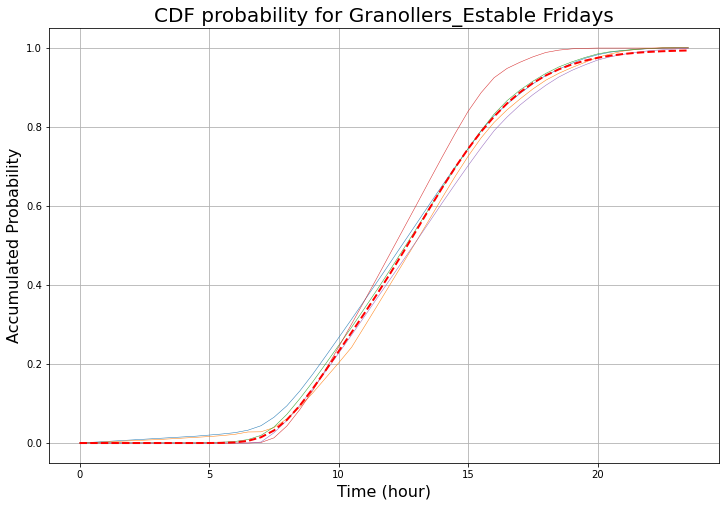

In [78]:
training_fridays_cdf = []
fig = plt.figure(figsize=(12,8))

for i in range(0, len(training_fridays_norm)):
    t = generate_cumulative(training_fridays_norm[i].values)
    training_fridays_cdf.append(t)
    plt.plot(time, t, linewidth=0.5)

gammix_friday_cdf = generate_cumulative(gammix_friday_n)
plt.title('CDF probability for ' + current_parking + ' Fridays', fontsize = 20)
plt.plot(time, gammix_friday_cdf, linewidth=2, color='red', linestyle='dashed')
plt.xlabel('Time (hour)', fontsize = 16)
plt.ylabel('Accumulated Probability', fontsize = 16)
plt.grid()

# training_weekdays_cdf
def cdf_error(proto, days):
    er=0
    for i in range(0,len(days)):
        er += np.abs(proto-days[i])
    return er/len(days)

# error = cdf_error()

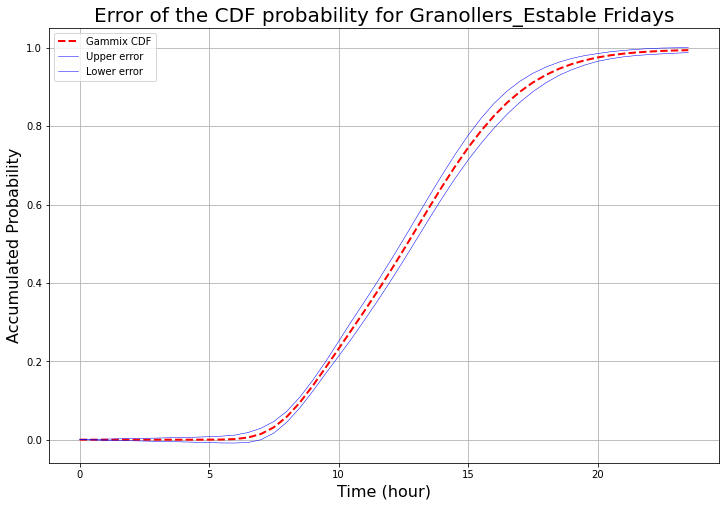

In [79]:
#Performance of the errors

cummulative_error_fridays = [];
error = np.zeros(len(gammix_friday_cdf));
for current_day in training_fridays_cdf:
    current_error = abs(np.array(current_day)-np.array(gammix_friday_cdf))
    cummulative_error_fridays.append(current_error)
    error += np.array(current_error)
error = error/len(training_fridays_cdf)


gammix_friday_cdf = generate_cumulative(gammix_friday_n)
fig = plt.figure(figsize=(12,8))
plt.title('Error of the CDF probability for ' + current_parking + ' Fridays', fontsize = 20)
plt.plot(time, gammix_friday_cdf, linewidth=2, color='red', linestyle='dashed', label='Gammix CDF')
plt.plot(time, gammix_friday_cdf - error, linewidth=0.5, color='blue', label = 'Upper error')
plt.plot(time, gammix_friday_cdf + error, linewidth=0.5, color='blue', label='Lower error')
plt.xlabel('Time (hour)', fontsize = 16)
plt.ylabel('Accumulated Probability', fontsize = 16)
plt.grid()
plt.legend()

## WEEKENDS

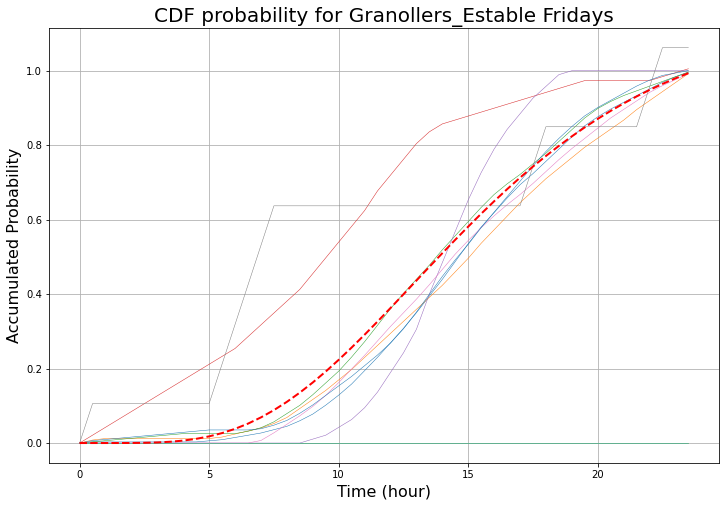

In [80]:
training_weekends_cdf = []
fig = plt.figure(figsize=(12,8))

for i in range(0, len(training_weekends_norm)):
    t = generate_cumulative(training_weekends_norm[i].values)
    training_weekends_cdf.append(t)
    plt.plot(time, t, linewidth=0.5)

gammix_weekend_cdf = generate_cumulative(gam1_weekend_n)
plt.title('CDF probability for ' + current_parking + ' Fridays', fontsize = 20)
plt.plot(time, gammix_weekend_cdf, linewidth=2, color='red', linestyle='dashed')
plt.xlabel('Time (hour)', fontsize = 16)
plt.ylabel('Accumulated Probability', fontsize = 16)
plt.grid()

# training_weekdays_cdf
def cdf_error(proto, days):
    er=0
    for i in range(0,len(days)):
        er += np.abs(proto-days[i])
    return er/len(days)

# error = cdf_error()

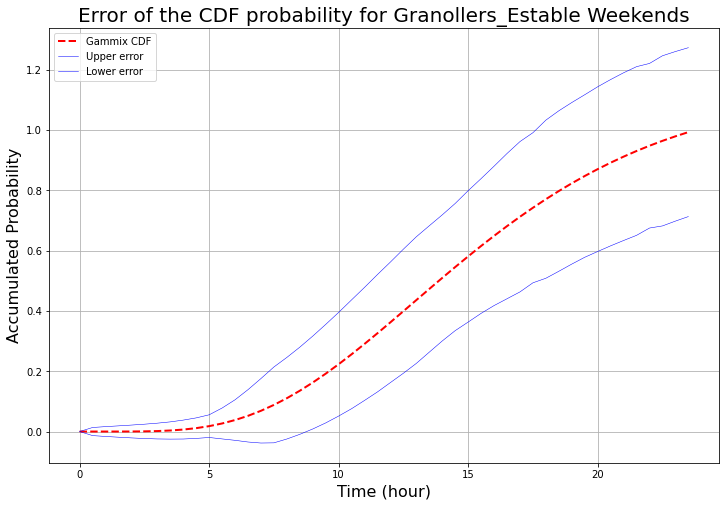

In [81]:
#Performance of the errors

cummulative_error_weekends = [];
error = np.zeros(len(gam1_weekend_n));
for current_day in training_weekends_cdf:
    current_error = abs(np.array(current_day)-np.array(gammix_weekend_cdf))
    cummulative_error_weekends.append(current_error)
    error += np.array(current_error)
error = error/len(training_weekends_cdf)


gammix_weekend_cdf = generate_cumulative(gam1_weekend_n)
fig = plt.figure(figsize=(12,8))
plt.title('Error of the CDF probability for ' + current_parking + ' Weekends', fontsize = 20)
plt.plot(time, gammix_weekend_cdf, linewidth=2, color='red', linestyle='dashed', label='Gammix CDF')
plt.plot(time, gammix_weekend_cdf - error, linewidth=0.5, color='blue', label = 'Upper error')
plt.plot(time, gammix_weekend_cdf + error, linewidth=0.5, color='blue', label='Lower error')
plt.xlabel('Time (hour)', fontsize = 16)
plt.ylabel('Accumulated Probability', fontsize = 16)
plt.grid()
plt.legend()

In [82]:
error

array([0.        , 0.01345195, 0.01632063, 0.0188201 , 0.02130883,
       0.02377083, 0.02618263, 0.02860423, 0.03138811, 0.03402942,
       0.03763114, 0.05125798, 0.06726042, 0.08685715, 0.10699766,
       0.12585394, 0.13533987, 0.14461725, 0.15409406, 0.1634343 ,
       0.17200295, 0.18057885, 0.18758425, 0.19478291, 0.19999325,
       0.20586215, 0.21008586, 0.20968095, 0.20921597, 0.21100905,
       0.21797591, 0.22356966, 0.23125631, 0.24098379, 0.24938572,
       0.24904057, 0.26235541, 0.26625295, 0.26802512, 0.26968341,
       0.27327478, 0.27589917, 0.27825585, 0.27983779, 0.27307186,
       0.28229544, 0.2813271 , 0.28018911])

# Store protos, params, areas and offsets

In [83]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_gammix_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_gammix_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_gammix_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in gammix_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in gam1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in gammix_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'Gammix_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'Gammix_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'Gammix_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'Gammix_weekday_params'] = weekday_gammix_params
# df_prototypes.at[index,'Gammix_friday_params']  = friday_gammix_params
# df_prototypes.at[index,'Gammix_weekend_params'] = weekend_gammix_params

# df_prototypes.at[index,'Gammix_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'Gammix_friday_area']  = friday_mean_area
# df_prototypes.at[index,'Gammix_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'Gammix_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'Gammix_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'Gammix_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [84]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'Gammix_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [85]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [86]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values